# Single-Cell RNA-Seq Analysis (BRN Skill Assessment) 
This project is part of the [BRN Skill Assessments](https://github.com/Bioinformatics-Research-Network/skill-assessments/tree/main/Single-Cell%20RNA-Seq%20Analysis). It presents my single cell RNA-seq comparision analysis of **adult and fetal human hearts**.  

Submitted by: Zain Ziad </br>
Date: 19-Jul-23

## a. Introduction: 
The aim of this project is to explore the gene expression patterns and differences between **adult** and **immature** (fetal) cardiomyocytes. I've integrated fetal and adult human hearts single cell data and compared cardiomyocytes from both stages. The analysis of these cell populations provides valuable information about cardiac development and maturation.
### The Dataset:
Two seperate raw datasets were used in this project:</br>
1- **Fetal scRNA-seq data**: GEO accession ```GSE216019```</br>
2- **Adult human heart scRNA-seq data**: [Heart Cell Atlas](https://www.heartcellatlas.org/#DataSources)</br>
#### Fetal scRNA-seq data:
Seven ```(F1-F7)``` fetal heart samples were available in the dataset (with seperate matrices of Apex and Base). Out of these seven samples, I have selected only ```F1``` and ```F2``` for analysis due to the scope and limitations of this project, as well as the computational resources available. 
#### Adult human heart scRNA-seq data:
This dataset also comprised a large number of cells, totaling approximately 486,134 cells, and was derived from 25 adult donors. I specifically selected donor ```D3``` as the primary focus, as it exhibited the most comprehensive gene expression profile among the different samples.

### The specific Questions that I plan to answer:
<li>How do gene expression profiles differ between adult and immature cardiomyocytes in the human heart?
<li>Which genes and pathways are specifically upregulated in immature cardiomyocytes?

<br />

# b. Importing important libraries
Here, I will import all of the python libraries that I will use in this project. <br/>
First, I am going to start by importing ```scvi-tools```. SCVI is a PyTorch and AnnData-based package designed for probabilistic modeling of single-cell omics data. It offers a collection of models that are specifically made for various single-cell data analysis tasks, which will be using throughout this project.

In [1]:
import scvi

e:\BIOINFO\.venv\Lib\site-packages\scvi\_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
e:\BIOINFO\.venv\Lib\site-packages\scvi\_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
e:\BIOINFO\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Next, we will be using: <br/>
- ```scanpy```, for most of the data preprocessing, visualization, clustering, etc. 
- ```pandas```, for data manipulation and for handling structured data.
- ```seaborn``` and ```matplotlib``` for additional data visualization. 
- ```numpy```, for a few numerical operations.

In [2]:
import scanpy as sc
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

And lastly, we will import ```gseapy``` to perform Pathway analysis. 

In [20]:
import gseapy as gp
from gseapy import barplot, dotplot

# c. Importing first sample

Let's go ahead and import our first sample from the ```fetal``` heart dataset as an AnnData object. Remember that each sample has two matrices inside, ```Apex``` and ```Base``` which were sequenced seperately. 

In [3]:
adata = sc.read_10x_mtx("Data\\F\\F1\\base")
adata

AnnData object with n_obs × n_vars = 5146 × 36601
    var: 'gene_ids', 'feature_types'

```F1``` Base has 5146 cells and 36,601 genes. In the ```.var``` dataframe, we have two columns that we don't need for now. 

In [4]:
adata.var = adata.var.drop(["feature_types"], axis=1)

# d. Doublet Prediction

We are going to start by predicting **doublets** in our data. **Doublets** arise in scRNA-seq data when two or more cells are mistakenly considered as a single cell. This can cause problems later when we are performing analysis. Thankfully, ```scvi-tools``` provides a pretty straight forward way to get rid of doublets.  <br/>
But first, we need to perform some basic pre processing using ```scanpy```. 

In [5]:
sc.pp.filter_cells(adata, min_genes=100)
adata

AnnData object with n_obs × n_vars = 5146 × 36601
    obs: 'n_genes'
    var: 'gene_ids'

In [6]:
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=True, flavor="seurat_v3")
adata

AnnData object with n_obs × n_vars = 5146 × 2000
    obs: 'n_genes'
    var: 'gene_ids', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'hvg'

Here, I've kept genes which are in atleast **3** cells, and selected the **2000** most highly variable genes. Next, I will initialize the ```scvi``` model and train it to predict doublets.

In [11]:
scvi.model.SCVI.setup_anndata(adata)
vae = scvi.model.SCVI(adata)
vae.train()
solo = scvi.external.SOLO.from_scvi_model(vae)
solo.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [01:35<00:00,  4.24it/s, v_num=1, train_loss_step=660, train_loss_epoch=580]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [01:35<00:00,  4.19it/s, v_num=1, train_loss_step=660, train_loss_epoch=580]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 286/400:  72%|███████▏  | 286/400 [01:05<00:26,  4.36it/s, v_num=1, train_loss_step=0.31, train_loss_epoch=0.356] 
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.328. Signaling Trainer to stop.


We can use the model to get a dataframe which has the predicted values. 

In [12]:
doublets_df = solo.predict()
doublets_df["prediction"] = solo.predict(soft=False)
doublets_df

doublet   singlet prediction
AAACCCAGTCAAAGTA-1  0.315254 -0.272025    doublet
AAACCCAGTCACTTAG-1  0.712583 -0.510041    doublet
AAACGAAAGGTTGACG-1 -0.923443  0.499203    singlet
AAACGAACAGACAAAT-1  0.434602 -0.129355    doublet
AAACGAACAGCTGTCG-1  0.805805 -1.024982    doublet
...                      ...       ...        ...
TTTGTTGAGATGCTGG-1  0.258590 -0.195698    doublet
TTTGTTGCAAAGACTA-1  0.665083 -0.468414    doublet
TTTGTTGGTTCCATTT-1  1.651886 -1.179968    doublet
TTTGTTGGTTCCCAAA-1  0.457216  0.097779    doublet
TTTGTTGTCGCAAGAG-1 -0.077888  0.000525    singlet

[5146 rows x 3 columns]

Percentage of Doublets in Dataset:  23.24 %


<Axes: xlabel='prediction', ylabel='count'>

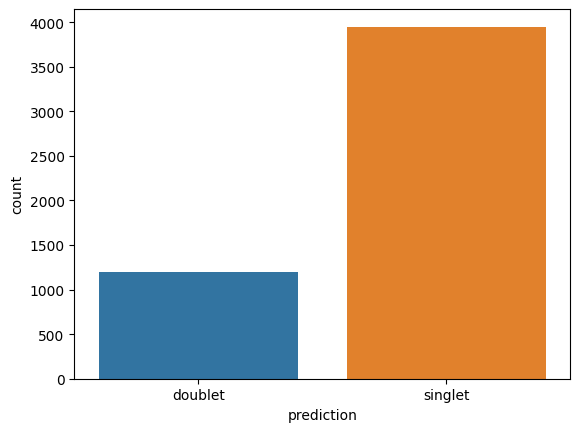

In [13]:
print(
    "Percentage of Doublets in Dataset: ",
    round(
        (len(doublets_df[doublets_df["prediction"] == "doublet"]) / len(doublets_df))
        * 100,
        2,
    ),
    "%",
)
sns.countplot(x=doublets_df["prediction"])

About **23.24%** of the total cells are predicted to be doublets. We can filter these out right now, but that number is resonably big. Instead, we can calculate the difference between the ```singlet``` and ```doublet``` columns and visualize it using a ```displot```.

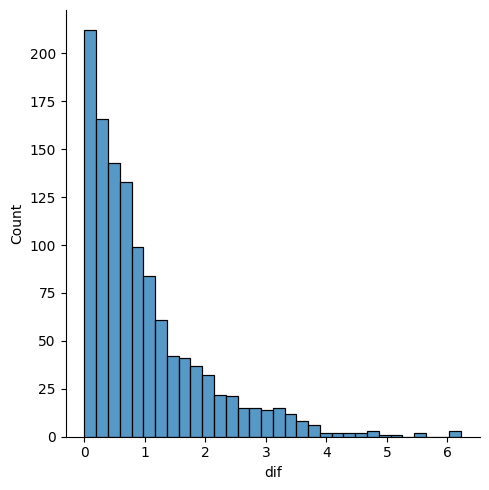

In [14]:
doublets_df["dif"] = doublets_df.doublet - doublets_df.singlet
sns.displot(doublets_df[doublets_df["prediction"] == "doublet"], x="dif")

We can see that there are a lot of cells below **1** that are predicted to be doublets (with low certainty). Let's keep those cells in our dataset and filter out the ones above 1. 

In [15]:
doublets_df = doublets_df[(doublets_df.prediction == "doublet") & (doublets_df.dif > 1)]
doublets_df

doublet   singlet prediction       dif
AAACCCAGTCACTTAG-1  0.712583 -0.510041    doublet  1.222623
AAACGAACAGCTGTCG-1  0.805805 -1.024982    doublet  1.830788
AAACGCTAGCCGTAAG-1  1.846159 -1.723460    doublet  3.569619
AAAGAACCAACACGAG-1  0.975117 -0.972957    doublet  1.948074
AAAGGATAGGTTTACC-1  0.914067 -0.742733    doublet  1.656800
...                      ...       ...        ...       ...
TTTGATCCAACAAGAT-1  1.424381 -0.940535    doublet  2.364916
TTTGGAGTCAGCCTCT-1  1.743106 -1.624937    doublet  3.368043
TTTGGTTTCTTCTTCC-1  1.572823 -1.072198    doublet  2.645020
TTTGTTGCAAAGACTA-1  0.665083 -0.468414    doublet  1.133497
TTTGTTGGTTCCATTT-1  1.651886 -1.179968    doublet  2.831854

[432 rows x 4 columns]

Now we have a dataframe of **432** cells that are predicted to be ```doublet``` with high certainty.

# e. Doublet Removal
The ```adata``` object has already been heavily processed for doublet prediction, so we need to import the dataset again. 

In [16]:
adata = sc.read_10x_mtx("Data\\F\\F1\\base")
adata.var = adata.var.drop(["feature_types"], axis=1)
adata

AnnData object with n_obs × n_vars = 5146 × 36601
    var: 'gene_ids'

And now we can simply use the cell ids to filter out the doublets from the freshly imported dataset. 

In [17]:
adata.obs["doublet"] = adata.obs.index.isin(doublets_df.index)
adata = adata[~adata.obs.doublet]
adata.obs

doublet
AAACCCAGTCAAAGTA-1    False
AAACGAAAGGTTGACG-1    False
AAACGAACAGACAAAT-1    False
AAACGAACAGTGCCTG-1    False
AAACGAACATCCGGTG-1    False
...                     ...
TTTGGTTGTCTAATCG-1    False
TTTGGTTGTTCGGTAT-1    False
TTTGTTGAGATGCTGG-1    False
TTTGTTGGTTCCCAAA-1    False
TTTGTTGTCGCAAGAG-1    False

[4714 rows x 1 columns]

We can now begin the general preprocessing of the data. 

# f. Preprocessing

I'm going to start by filtering out cells which have fewer than **100 genes**, and genes that are present in fewer than **3 cells**. 

In [18]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)
adata

e:\BIOINFO\.venv\Lib\site-packages\scanpy\preprocessing\_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


AnnData object with n_obs × n_vars = 4714 × 22503
    obs: 'doublet', 'n_genes'
    var: 'gene_ids', 'n_cells'

Next, we need to label the mitochondrial genes. These are usually labelled with **"MT-"** in human datasets. 

In [19]:
adata.var["mt"] = adata.var_names.str.startswith("MT-")
adata.var

gene_ids  n_cells     mt
AL627309.1  ENSG00000238009        4  False
AL627309.5  ENSG00000241860       53  False
LINC01409   ENSG00000237491      171  False
LINC01128   ENSG00000228794      644  False
LINC00115   ENSG00000225880       59  False
...                     ...      ...    ...
AL354822.1  ENSG00000278384       13  False
AL592183.1  ENSG00000273748      108  False
AC240274.1  ENSG00000271254       83  False
AC007325.4  ENSG00000278817      111  False
AC007325.2  ENSG00000277196        3  False

[22503 rows x 3 columns]

To label the ribosomal genes, I'm going to use the ```KEGG_RIBOSOME``` dataset from the following link. 

In [20]:
ribo_genes = pd.read_table(
    "http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp?geneSetName=KEGG_RIBOSOME&fileType=txt",
    skiprows=2,
    header=None,
)
ribo_genes

0
0          FAU
1       MRPL13
2        RPL10
3       RPL10A
4       RPL10L
..         ...
83        RPS9
84        RPSA
85     RSL24D1
86  RSL24D1P11
87       UBA52

[88 rows x 1 columns]

And then we can simply use this dataset to label ribosomal genes in our ```adata``` object. 

In [21]:
adata.var["ribo"] = adata.var_names.isin(ribo_genes[0].values)
adata.var.loc[adata.var["ribo"] == True]

gene_ids  n_cells     mt  ribo
RPL22   ENSG00000116251     3879  False  True
RPL11   ENSG00000142676     4379  False  True
RPS8    ENSG00000142937     4377  False  True
RPL5    ENSG00000122406     4238  False  True
RPS27   ENSG00000177954     4205  False  True
...                 ...      ...    ...   ...
RPL3    ENSG00000100316     4390  False  True
RPS4X   ENSG00000198034     4479  False  True
RPL36A  ENSG00000241343     3787  False  True
RPL39   ENSG00000198918     4148  False  True
RPL10   ENSG00000147403     4635  False  True

[84 rows x 4 columns]

Next, we need to calculate some important QC metrics using ```scanpy```.

In [22]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo"], percent_top=None, log1p=False, inplace=True
)
adata

AnnData object with n_obs × n_vars = 4714 × 22503
    obs: 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'gene_ids', 'n_cells', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

So here, we can see ```scanpy``` calculated and added a few columns in our ```adata``` object. The ones that we will be looking at are mainly: <br />
```n_genes_by_counts```, which is the number of genes with at least 1 count in a cell.<br />
```total_counts```, sum of counts for a gene.<br />
```pct_counts_mt```, proportion of total counts for a cell which are mitochondrial.<br />
```pct_counts_ribo```, proportion of total counts for a cell which are ribosomal.<br />
<br />
We can use ```scanpy``` violin plots to visualize these columns. 

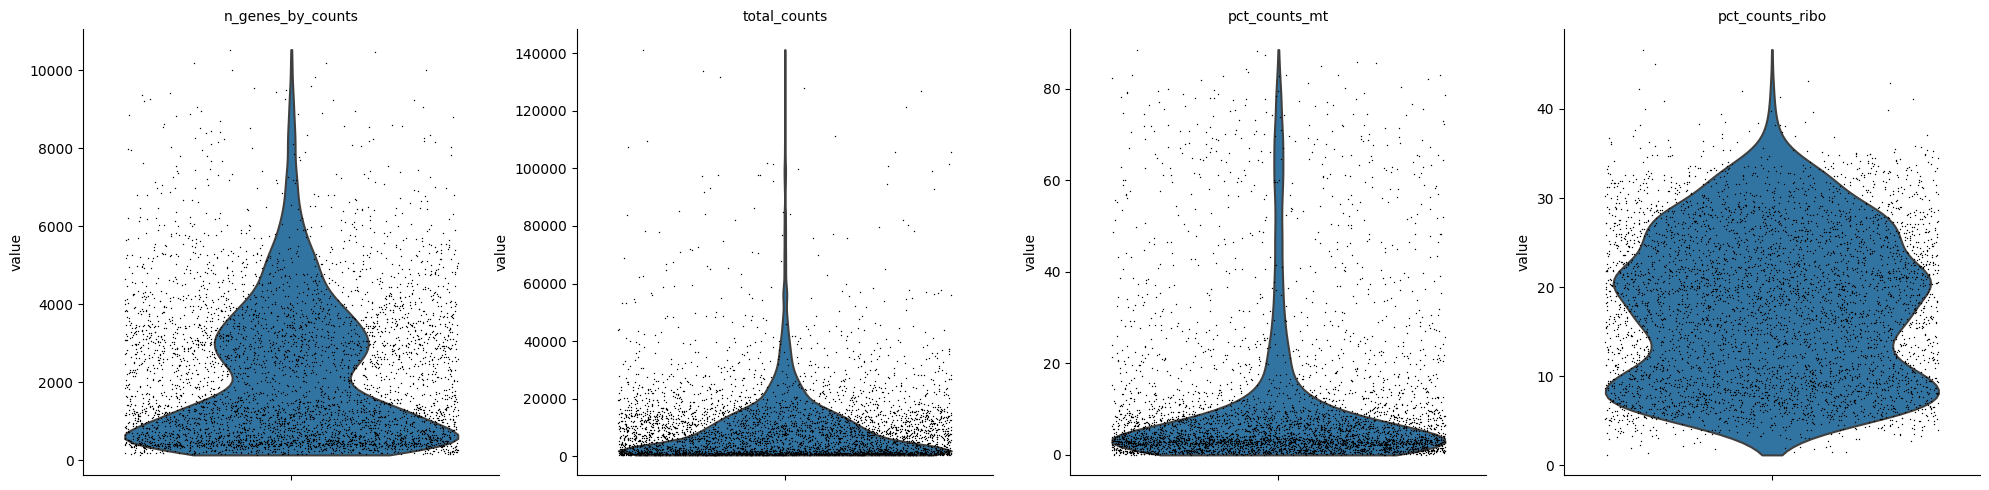

In [23]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt", "pct_counts_ribo"],
    jitter=0.4,
    multi_panel=True,
)

We are going to use these calculated qc metrics to get rid of **outliers**. <br/>
If a cell has a significantly higher amount of genes (as shown by the ```n_genes_by_counts``` column) than the average, then it could be a sequencing artifact. Same goes for ```pct_counts_mt``` and ```pct_counts_ribo```, which can also indicate if the cell might be dying. <br/>
First, We're going to filter the outliers in ```n_genes_by_counts``` column by calculating the 98th percentile of that column. 

In [24]:
upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, 0.98)
upper_lim

7119.74

In [25]:
adata = adata[adata.obs.n_genes_by_counts < upper_lim]
adata.obs.sort_values(by="n_genes_by_counts")

doublet  n_genes  n_genes_by_counts  total_counts  \
GTCACTCGTCGCTCGA-1    False      136                136         943.0   
TCGCTTGTCCATCTGC-1    False      141                141        1112.0   
ATCATTCCATTATGCG-1    False      146                146         788.0   
GGGTGTCAGAGCAGAA-1    False      153                153         955.0   
GTTATGGTCGGTTGTA-1    False      155                155         573.0   
...                     ...      ...                ...           ...   
CATTGCCAGCTGTTCA-1    False     7063               7052       47316.0   
CACATGATCTTCCTAA-1    False     7093               7088       42090.0   
TCTAACTTCGCTCTCA-1    False     7096               7092       40244.0   
GTAGAAATCGCTCATC-1    False     7112               7110       45942.0   
CCGTTCAGTGCCTACG-1    False     7123               7119       41264.0   

                    total_counts_mt  pct_counts_mt  total_counts_ribo  \
GTCACTCGTCGCTCGA-1            790.0      83.775185               51.0   
TCGCTTGTCCATCTGC-1            939.0      84.442451               52.0   
ATCATTCCATTATGCG-1            629.0      79.822334               47.0   
GGGTGTCAGAGCAGAA-1            784.0      82.094238               56.0   
GTTATGGTCGGTTGTA-1            402.0      70.157066               47.0   
...                             ...            ...                ...   
CATTGCCAGCTGTTCA-1           1658.0       3.504100            15604.0   
CACATGATCTTCCTAA-1            822.0       1.952958             8358.0   
TCTAACTTCGCTCTCA-1            982.0       2.440115            10541.0   
GTAGAAATCGCTCATC-1           2869.0       6.244831             9145.0   
CCGTTCAGTGCCTACG-1           1175.0       2.847518             8910.0   

                    pct_counts_ribo  
GTCACTCGTCGCTCGA-1         5.408271  
TCGCTTGTCCATCTGC-1         4.676259  
ATCATTCCATTATGCG-1         5.964467  
GGGTGTCAGAGCAGAA-1         5.863874  
GTTATGGTCGGTTGTA-1         8.202443  
...                             ...  
CATTGCCAGCTGTTCA-1        32.978271  
CACATGATCTTCCTAA-1        19.857449  
TCTAACTTCGCTCTCA-1        26.192724  
GTAGAAATCGCTCATC-1        19.905533  
CCGTTCAGTGCCTACG-1        21.592672  

[4619 rows x 8 columns]

To filter ```pct_counts_mt```, I'm going to use a value of **25**. <br/>
And for ribosomal count (```pct_counts_ribo```), I'm going to filter out all of the cells above **35**. 

In [26]:
adata = adata[adata.obs.pct_counts_mt < 25]
adata = adata[adata.obs.pct_counts_ribo < 35]
adata

View of AnnData object with n_obs × n_vars = 4031 × 22503
    obs: 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'gene_ids', 'n_cells', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

Now we have **4031 cells** and **22503 genes** left in our dataset. We can plot the QC metrics again and see values are well distributed now. 

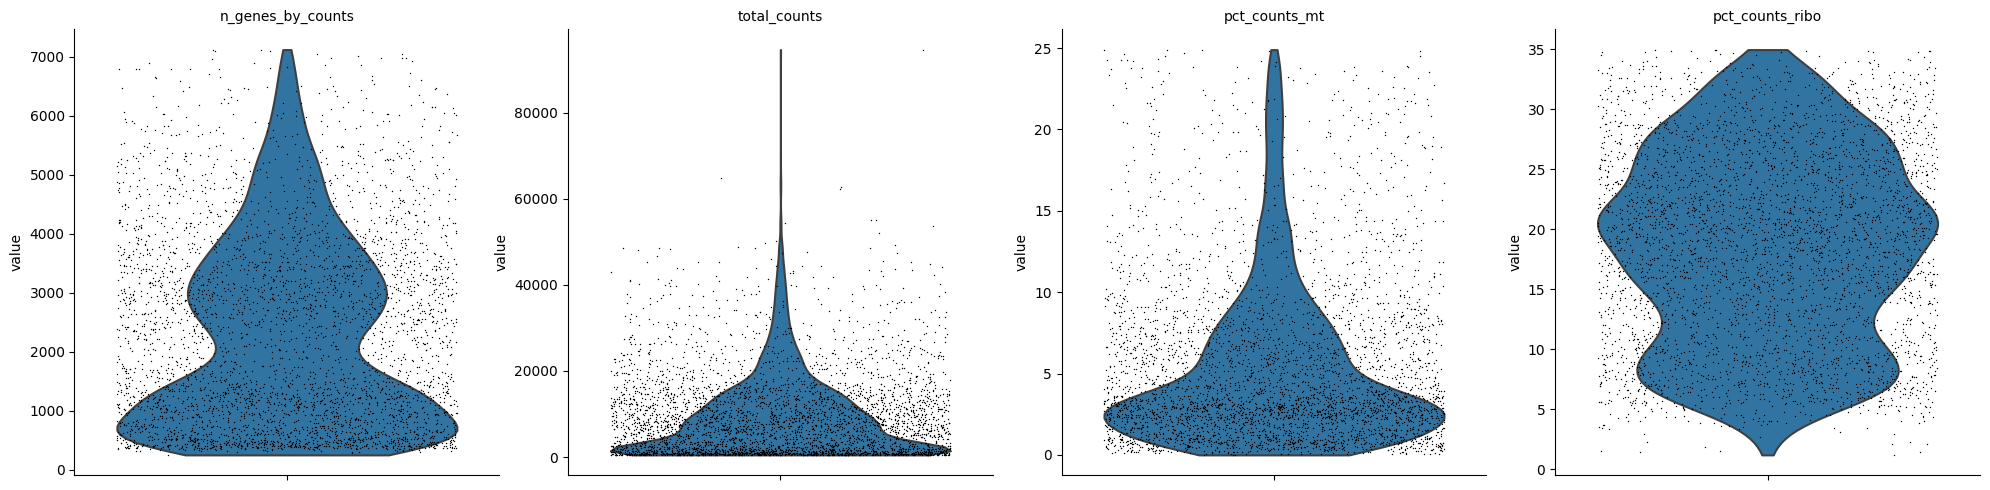

In [27]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt", "pct_counts_ribo"],
    jitter=0.4,
    multi_panel=True,
)

Lastly, I'm going to add a ```sample``` column, which specifies which donor the cells are from. And a ```condition``` column, which tells whether the cell is from the adult heart dataset or fetal heart. 

In [28]:
adata.obs["sample"] = "F1"
adata.obs["condition"] = "foetal"
adata.obs

C:\Users\Zain\AppData\Local\Temp\ipykernel_16276\997751919.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['sample'] = 'F1'


doublet  n_genes  n_genes_by_counts  total_counts  \
AAACCCAGTCAAAGTA-1    False      755                755        1686.0   
AAACGAAAGGTTGACG-1    False     4233               4230       16298.0   
AAACGAACAGACAAAT-1    False     1249               1249        8305.0   
AAACGAATCAAGTGTC-1    False     1620               1620        3377.0   
AAACGAATCGCCAATA-1    False     4477               4475       20710.0   
...                     ...      ...                ...           ...   
TTTGGTTGTCTAATCG-1    False      393                393         586.0   
TTTGGTTGTTCGGTAT-1    False     4939               4938       33792.0   
TTTGTTGAGATGCTGG-1    False     1093               1093        7679.0   
TTTGTTGGTTCCCAAA-1    False     5046               5044       24139.0   
TTTGTTGTCGCAAGAG-1    False     2082               2078        6089.0   

                    total_counts_mt  pct_counts_mt  total_counts_ribo  \
AAACCCAGTCAAAGTA-1             87.0       5.160142              100.0   
AAACGAAAGGTTGACG-1            528.0       3.239661             4009.0   
AAACGAACAGACAAAT-1             42.0       0.505719              316.0   
AAACGAATCAAGTGTC-1             70.0       2.072846              823.0   
AAACGAATCGCCAATA-1            836.0       4.036697             4386.0   
...                             ...            ...                ...   
TTTGGTTGTCTAATCG-1             22.0       3.754266              150.0   
TTTGGTTGTTCGGTAT-1           2761.0       8.170572             4954.0   
TTTGTTGAGATGCTGG-1             46.0       0.599036              707.0   
TTTGTTGGTTCCCAAA-1            876.0       3.628982             7540.0   
TTTGTTGTCGCAAGAG-1           1396.0      22.926588              320.0   

                    pct_counts_ribo sample condition  
AAACCCAGTCAAAGTA-1         5.931198     F1    foetal  
AAACGAAAGGTTGACG-1        24.598110     F1    foetal  
AAACGAACAGACAAAT-1         3.804937     F1    foetal  
AAACGAATCAAGTGTC-1        24.370743     F1    foetal  
AAACGAATCGCCAATA-1        21.178175     F1    foetal  
...                             ...    ...       ...  
TTTGGTTGTCTAATCG-1        25.597269     F1    foetal  
TTTGGTTGTTCGGTAT-1        14.660275     F1    foetal  
TTTGTTGAGATGCTGG-1         9.206928     F1    foetal  
TTTGTTGGTTCCCAAA-1        31.235760     F1    foetal  
TTTGTTGTCGCAAGAG-1         5.255378     F1    foetal  

[4031 rows x 10 columns]

# g. Integration

We can move towards integrating our samples into one ```AnnData``` object. <br/>
Remember that we have **4 total fetal heart samples** (F1, F2: Apex and Base) and **1 Adult heart sample**. ```F1``` Base has already been processed, so let's add it to a list. We can later append this list with additional Adata objects as we perform preprocessing on them.

In [29]:
out = []
out.append(adata)

Instead of repeating all of the steps above for each individual sample, I've made a simple function that contains basically the same lines of code. We can use this function to process all of our fetal heart samples. 

In [30]:
def preprocess(file, sample):
    print("Working on " + sample + "...")
    adata = sc.read_10x_mtx(file)
    adata.var = adata.var.drop(["feature_types"], axis=1)
    # Doublet Detection
    sc.pp.filter_cells(adata, min_genes=100)
    sc.pp.filter_genes(adata, min_cells=3)
    sc.pp.highly_variable_genes(
        adata, n_top_genes=2000, subset=True, flavor="seurat_v3"
    )
    scvi.model.SCVI.setup_anndata(adata)
    vae = scvi.model.SCVI(adata)
    vae.train()
    solo = scvi.external.SOLO.from_scvi_model(vae)
    solo.train(batch_size=129)
    df = solo.predict()
    df["prediction"] = solo.predict(soft=False)
    df["dif"] = df.doublet - df.singlet
    doublets = df[(df.prediction == "doublet") & (df.dif > 1)]
    # Doublet removal
    adata = sc.read_10x_mtx(file)
    adata.var = adata.var.drop(["feature_types"], axis=1)
    adata.obs["sample"] = sample
    adata.obs["condition"] = "foetal"
    adata.obs["doublet"] = adata.obs.index.isin(doublets.index)
    adata = adata[~adata.obs.doublet]
    # Preprocessing
    sc.pp.filter_cells(adata, min_genes=100)
    sc.pp.filter_genes(adata, min_cells=3)
    adata.var["mt"] = adata.var_names.str.startswith("MT-")
    adata.var["ribo"] = adata.var_names.isin(ribo_genes[0].values)
    sc.pp.calculate_qc_metrics(
        adata, qc_vars=["mt", "ribo"], percent_top=None, log1p=False, inplace=True
    )
    upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, 0.98)
    adata = adata[adata.obs.n_genes_by_counts < upper_lim]
    adata = adata[adata.obs.pct_counts_mt < 25]
    adata = adata[adata.obs.pct_counts_ribo < 35]
    return adata

Let's first process ```F1 Apex```

In [31]:
out.append(preprocess("Data\\F\\F1\\apex\\", "F1"))

Working on F1...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [02:05<00:00,  3.16it/s, v_num=1, train_loss_step=639, train_loss_epoch=622]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [02:05<00:00,  3.18it/s, v_num=1, train_loss_step=639, train_loss_epoch=622]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 320/400:  80%|████████  | 320/400 [01:37<00:24,  3.28it/s, v_num=1, train_loss_step=0.349, train_loss_epoch=0.309]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.296. Signaling Trainer to stop.


e:\BIOINFO\.venv\Lib\site-packages\scanpy\preprocessing\_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


And now ```F2 Apex``` and ```Base```

In [32]:
for x in ["\\base\\", "\\apex\\"]:
    loc = "Data\\F\\F2\\" + x
    out.append(preprocess(loc, "F2"))

Working on F2...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [01:58<00:00,  3.35it/s, v_num=1, train_loss_step=409, train_loss_epoch=406]

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [01:58<00:00,  3.36it/s, v_num=1, train_loss_step=409, train_loss_epoch=406]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 245/400:  61%|██████▏   | 245/400 [01:10<00:44,  3.48it/s, v_num=1, train_loss_step=0.453, train_loss_epoch=0.356]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.324. Signaling Trainer to stop.


e:\BIOINFO\.venv\Lib\site-packages\scanpy\preprocessing\_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


Working on F2...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 400/400: 100%|██████████| 400/400 [01:44<00:00,  3.77it/s, v_num=1, train_loss_step=228, train_loss_epoch=463]    

`Trainer.fit` stopped: `max_epochs=400` reached.


Epoch 400/400: 100%|██████████| 400/400 [01:44<00:00,  3.84it/s, v_num=1, train_loss_step=228, train_loss_epoch=463]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 227/400:  57%|█████▋    | 227/400 [00:56<00:43,  4.01it/s, v_num=1, train_loss_step=0.349, train_loss_epoch=0.349]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.334. Signaling Trainer to stop.


e:\BIOINFO\.venv\Lib\site-packages\scanpy\preprocessing\_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


We can look at our ```out``` list, which should contain 4 seperate ```AnnData``` objects inside. 

In [33]:
out

[AnnData object with n_obs × n_vars = 4031 × 22503
     obs: 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'sample', 'condition'
     var: 'gene_ids', 'n_cells', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts',
 View of AnnData object with n_obs × n_vars = 5715 × 21864
     obs: 'sample', 'condition', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
     var: 'gene_ids', 'n_cells', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts',
 View of AnnData object with n_obs × n_vars = 5102 × 23385
     obs: 'sample', 'condition', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
     var: 'gene_ids', 'n_cells', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts',

Here we can see that all of the fetal samples were processed successfully and added to this list. We can now ```concat``` this list into one ```AnnData``` object.  

In [34]:
adata = sc.concat(out)
adata

e:\BIOINFO\.venv\Lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 19350 × 19720
    obs: 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'sample', 'condition'

In [35]:
adata.obs.groupby("sample").count().reset_index()

sample  doublet  n_genes  n_genes_by_counts  total_counts  total_counts_mt  \
0     F1     9746     9746               9746          9746             9746   
1     F2     9604     9604               9604          9604             9604   

   pct_counts_mt  total_counts_ribo  pct_counts_ribo  condition  
0           9746               9746             9746       9746  
1           9604               9604             9604       9604

So we have **19,350 cells** in total, out of which, **9746** are from sample ```F1``` and **9604** are from sample ```F2```. 

In [36]:
adata.obs_names_make_unique()

In [37]:
adata.write_h5ad("adata_foetal_final.h5ad")

### Adult Sample

Since the adult heart sample is from a different dataset and a different study, it's better we process it manually. Let's start by importing it as ```adata```. 

In [38]:
adata = sc.read_h5ad("Data\\A\\adult_global_raw.h5ad")
adata

AnnData object with n_obs × n_vars = 486134 × 33538
    obs: 'NRP', 'age_group', 'cell_source', 'cell_type', 'donor', 'gender', 'n_counts', 'n_genes', 'percent_mito', 'percent_ribo', 'region', 'sample', 'scrublet_score', 'source', 'type', 'version', 'cell_states', 'Used'
    var: 'gene_ids-Harvard-Nuclei', 'feature_types-Harvard-Nuclei', 'gene_ids-Sanger-Nuclei', 'feature_types-Sanger-Nuclei', 'gene_ids-Sanger-Cells', 'feature_types-Sanger-Cells', 'gene_ids-Sanger-CD45', 'feature_types-Sanger-CD45'
    uns: 'cell_type_colors'
    obsm: 'X_pca', 'X_umap'

The dataset contains columns that we don't really need for this project, so I ended up removing them. 

In [39]:
adata.var = adata.var.drop(
    [
        "gene_ids-Harvard-Nuclei",
        "feature_types-Harvard-Nuclei",
        "gene_ids-Sanger-Nuclei",
        "feature_types-Sanger-Nuclei",
        "gene_ids-Sanger-Cells",
        "feature_types-Sanger-Cells",
        "gene_ids-Sanger-CD45",
        "feature_types-Sanger-CD45",
    ],
    axis=1,
)

In [40]:
adata.obs

NRP age_group     cell_source  \
AAACCCAAGAACGCGT-1-H0015_apex        No     50-55  Harvard-Nuclei   
AAACCCAAGCAAACAT-1-H0015_apex        No     50-55  Harvard-Nuclei   
AAACCCAAGCTACTGT-1-H0015_apex        No     50-55  Harvard-Nuclei   
AAACCCAGTACCGCGT-1-H0015_apex        No     50-55  Harvard-Nuclei   
AAACCCATCAAACCCA-1-H0015_apex        No     50-55  Harvard-Nuclei   
...                                 ...       ...             ...   
TTTGTTGTCATACGGT-1-HCAHeart8102862  Yes     60-65     Sanger-CD45   
TTTGTTGTCCTACCAC-1-HCAHeart8102862  Yes     60-65     Sanger-CD45   
TTTGTTGTCGACGCTG-1-HCAHeart8102862  Yes     60-65     Sanger-CD45   
TTTGTTGTCGGCTGAC-1-HCAHeart8102862  Yes     60-65     Sanger-CD45   
TTTGTTGTCGGTGTTA-1-HCAHeart8102862  Yes     60-65     Sanger-CD45   

                                                    cell_type donor  gender  \
AAACCCAAGAACGCGT-1-H0015_apex             Smooth_muscle_cells    H5  Female   
AAACCCAAGCAAACAT-1-H0015_apex       Ventricular_Cardiomyocyte    H5  Female   
AAACCCAAGCTACTGT-1-H0015_apex       Ventricular_Cardiomyocyte    H5  Female   
AAACCCAGTACCGCGT-1-H0015_apex                       Pericytes    H5  Female   
AAACCCATCAAACCCA-1-H0015_apex       Ventricular_Cardiomyocyte    H5  Female   
...                                                       ...   ...     ...   
TTTGTTGTCATACGGT-1-HCAHeart8102862                Endothelial   D11  Female   
TTTGTTGTCCTACCAC-1-HCAHeart8102862                Endothelial   D11  Female   
TTTGTTGTCGACGCTG-1-HCAHeart8102862                Endothelial   D11  Female   
TTTGTTGTCGGCTGAC-1-HCAHeart8102862                Endothelial   D11  Female   
TTTGTTGTCGGTGTTA-1-HCAHeart8102862                Endothelial   D11  Female   

                                    n_counts  n_genes  percent_mito  \
AAACCCAAGAACGCGT-1-H0015_apex          688.0      480      0.004360   
AAACCCAAGCAAACAT-1-H0015_apex         3216.0     1365      0.000933   
AAACCCAAGCTACTGT-1-H0015_apex         3182.0     1521      0.000943   
AAACCCAGTACCGCGT-1-H0015_apex         1202.0      726      0.000832   
AAACCCATCAAACCCA-1-H0015_apex         3804.0     1584      0.000263   
...                                      ...      ...           ...   
TTTGTTGTCATACGGT-1-HCAHeart8102862    1619.0      904      0.087708   
TTTGTTGTCCTACCAC-1-HCAHeart8102862    1186.0      692      0.126476   
TTTGTTGTCGACGCTG-1-HCAHeart8102862    1672.0      847      0.145335   
TTTGTTGTCGGCTGAC-1-HCAHeart8102862    4676.0     1925      0.163388   
TTTGTTGTCGGTGTTA-1-HCAHeart8102862    3144.0     1422      0.097010   

                                    percent_ribo region           sample  \
AAACCCAAGAACGCGT-1-H0015_apex           0.002907     AX       H0015_apex   
AAACCCAAGCAAACAT-1-H0015_apex           0.001244     AX       H0015_apex   
AAACCCAAGCTACTGT-1-H0015_apex           0.002200     AX       H0015_apex   
AAACCCAGTACCGCGT-1-H0015_apex           0.000000     AX       H0015_apex   
AAACCCATCAAACCCA-1-H0015_apex           0.001314     AX       H0015_apex   
...                                          ...    ...              ...   
TTTGTTGTCATACGGT-1-HCAHeart8102862      0.024707     AX  HCAHeart8102862   
TTTGTTGTCCTACCAC-1-HCAHeart8102862      0.015177     AX  HCAHeart8102862   
TTTGTTGTCGACGCTG-1-HCAHeart8102862      0.044258     AX  HCAHeart8102862   
TTTGTTGTCGGCTGAC-1-HCAHeart8102862      0.044482     AX  HCAHeart8102862   
TTTGTTGTCGGTGTTA-1-HCAHeart8102862      0.026081     AX  HCAHeart8102862   

                                    scrublet_score  source type version  \
AAACCCAAGAACGCGT-1-H0015_apex             0.035917  Nuclei  DBD      V3   
AAACCCAAGCAAACAT-1-H0015_apex             0.147122  Nuclei  DBD      V3   
AAACCCAAGCTACTGT-1-H0015_apex             0.185751  Nuclei  DBD      V3   
AAACCCAGTACCGCGT-1-H0015_apex             0.035917  Nuclei  DBD      V3   
AAACCCATCAAACCCA-1-H0015_apex             0.108062  Nuclei  DBD      V3   
...                                       

The Cell IDs contain appended sample names, which we need to remove. 

In [41]:
adata.obs.index = adata.obs.index.to_series().str.split("-").str[:2].str.join("-")

And finally, I've only kept cells from donor ```D3``` for this project. 

In [42]:
adata = adata[adata.obs["donor"] == "D3"]

In [43]:
adata.obs

NRP age_group    cell_source            cell_type donor  \
AAACCTGAGGTTACCT-1  No     55-60  Sanger-Nuclei              Myeloid    D3   
AAACCTGCAACTGGCC-1  No     55-60  Sanger-Nuclei          Endothelial    D3   
AAACCTGCAAGAGGCT-1  No     55-60  Sanger-Nuclei           Fibroblast    D3   
AAACCTGCATTAGCCA-1  No     55-60  Sanger-Nuclei           Fibroblast    D3   
AAACCTGGTTTGACAC-1  No     55-60  Sanger-Nuclei          Endothelial    D3   
...                 ..       ...            ...                  ...   ...   
TTTGCGCGTTATCCGA-1  No     55-60   Sanger-Cells              Myeloid    D3   
TTTGCGCGTTCCTCCA-1  No     55-60   Sanger-Cells              Myeloid    D3   
TTTGCGCGTTTCCACC-1  No     55-60   Sanger-Cells          Endothelial    D3   
TTTGGTTAGTTCCACA-1  No     55-60   Sanger-Cells          Endothelial    D3   
TTTGGTTTCACGCGGT-1  No     55-60   Sanger-Cells  Smooth_muscle_cells    D3   

                   gender  n_counts  n_genes  percent_mito  percent_ribo  \
AAACCTGAGGTTACCT-1   Male     971.0      614      0.003090      0.001030   
AAACCTGCAACTGGCC-1   Male    1072.0      667      0.002799      0.003731   
AAACCTGCAAGAGGCT-1   Male    1466.0      925      0.008186      0.003411   
AAACCTGCATTAGCCA-1   Male    1945.0     1180      0.000000      0.003085   
AAACCTGGTTTGACAC-1   Male    1419.0      953      0.006342      0.002819   
...                   ...       ...      ...           ...           ...   
TTTGCGCGTTATCCGA-1   Male    4935.0     1626      0.119757      0.053495   
TTTGCGCGTTCCTCCA-1   Male    6899.0     2104      0.063632      0.064212   
TTTGCGCGTTTCCACC-1   Male    2406.0     1024      0.118869      0.090191   
TTTGGTTAGTTCCACA-1   Male    2468.0     1075      0.160454      0.036872   
TTTGGTTTCACGCGGT-1   Male    3472.0     1071      0.129320      0.058756   

                   region           sample  scrublet_score  source type  \
AAACCTGAGGTTACCT-1     LV  HCAHeart7664654        0.039216  Nuclei  DBD   
AAACCTGCAACTGGCC-1     LV  HCAHeart7664654        0.023596  Nuclei  DBD   
AAACCTGCAAGAGGCT-1     LV  HCAHeart7664654        0.113475  Nuclei  DBD   
AAACCTGCATTAGCCA-1     LV  HCAHeart7664654        0.102990  Nuclei  DBD   
AAACCTGGTTTGACAC-1     LV  HCAHeart7664654        0.074830  Nuclei  DBD   
...                   ...              ...             ...     ...  ...   
TTTGCGCGTTATCCGA-1     AX  HCAHeart7656538        0.132150   Cells  DBD   
TTTGCGCGTTCCTCCA-1     AX  HCAHeart7656538        0.125475   Cells  DBD   
TTTGCGCGTTTCCACC-1     AX  HCAHeart7656538        0.052988   Cells  DBD   
TTTGGTTAGTTCCACA-1     AX  HCAHeart7656538        0.031390   Cells  DBD   
TTTGGTTTCACGCGGT-1     AX  HCAHeart7656538        0.119266   Cells  DBD   

                   version cell_states Used  
AAACCTGAGGTTACCT-1      V2   DOCK4+MØ2  Yes  
AAACCTGCAACTGGCC-1      V2     EC1_cap  Yes  
AAACCTGCAAGAGGCT-1      V2         FB4  Yes  
AAACCTGCATTAGCCA-1      V2         FB4  Yes  
AAACCTGGTTTGACAC-1      V2     EC1_cap  Yes  
...                    ...         ...  ...  
TTTGCGCGTTATCCGA-1      V2     CD16+Mo  Yes  
TTTGCGCGTTCCTCCA-1      V2   LYVE1+MØ1  Yes  
TTTGCGCGTTTCCACC-1      V2     EC5_art  Yes  
TTTGGTTAGTTCCACA-1      V2     EC1_cap  Yes  
TTTGGTTTCACGCGGT-1      V2    SMC2_art  Yes  

[27022 rows x 18 columns]

Some basic data cleaning. 

In [44]:
adata.obs = adata.obs.drop(
    [
        "NRP",
        "age_group",
        "cell_source",
        "cell_type",
        "gender",
        "n_counts",
        "n_genes",
        "percent_mito",
        "percent_ribo",
        "region",
        "sample",
        "scrublet_score",
        "source",
        "type",
        "version",
        "cell_states",
        "Used",
    ],
    axis=1,
)
adata.obs.rename(columns={"donor": "sample"}, inplace=True)
adata.obs

e:\BIOINFO\.venv\Lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


sample
AAACCTGAGGTTACCT-1     D3
AAACCTGCAACTGGCC-1     D3
AAACCTGCAAGAGGCT-1     D3
AAACCTGCATTAGCCA-1     D3
AAACCTGGTTTGACAC-1     D3
...                   ...
TTTGCGCGTTATCCGA-1     D3
TTTGCGCGTTCCTCCA-1     D3
TTTGCGCGTTTCCACC-1     D3
TTTGGTTAGTTCCACA-1     D3
TTTGGTTTCACGCGGT-1     D3

[27022 rows x 1 columns]

In [45]:
adata.obs_names_make_unique()

### Doublet Removal

Now we can detect and remove doublets in this dataset. I followed the same workflow here as before. 

In [46]:
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=True, flavor="seurat_v3")
adata

AnnData object with n_obs × n_vars = 27022 × 2000
    obs: 'sample', 'n_genes'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm'
    uns: 'cell_type_colors', 'hvg'
    obsm: 'X_pca', 'X_umap'

In [47]:
scvi.model.SCVI.setup_anndata(adata)
vae = scvi.model.SCVI(adata)
vae.train()
solo = scvi.external.SOLO.from_scvi_model(vae)
solo.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 296/296: 100%|██████████| 296/296 [05:57<00:00,  1.19s/it, v_num=1, train_loss_step=434, train_loss_epoch=452]

`Trainer.fit` stopped: `max_epochs=296` reached.


Epoch 296/296: 100%|██████████| 296/296 [05:57<00:00,  1.21s/it, v_num=1, train_loss_step=434, train_loss_epoch=452]
INFO     Creating doublets, preparing SOLO model.                                                                  


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 149/400:  37%|███▋      | 149/400 [02:54<04:54,  1.17s/it, v_num=1, train_loss_step=0.201, train_loss_epoch=0.198]
Monitored metric validation_loss did not improve in the last 30 records. Best score: 0.180. Signaling Trainer to stop.


Percentage of Doublets in Dataset:  10.86 %


<Axes: xlabel='prediction', ylabel='count'>

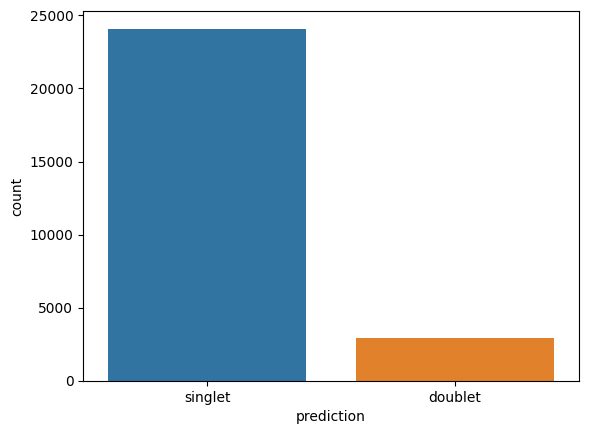

In [48]:
doublets_df = solo.predict()
doublets_df["prediction"] = solo.predict(soft=False)
print(
    "Percentage of Doublets in Dataset: ",
    round(
        (len(doublets_df[doublets_df["prediction"] == "doublet"]) / len(doublets_df))
        * 100,
        2,
    ),
    "%",
)
sns.countplot(x=doublets_df["prediction"])

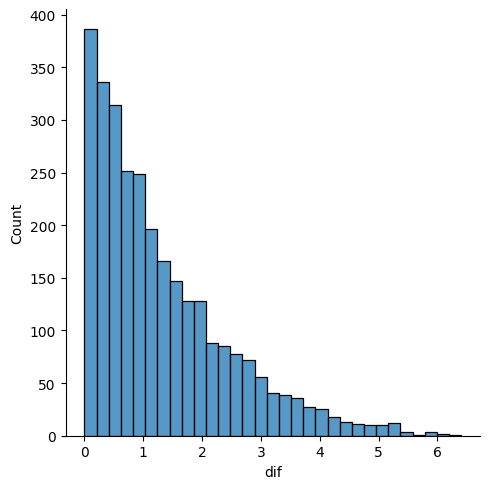

In [49]:
doublets_df["dif"] = doublets_df.doublet - doublets_df.singlet
sns.displot(doublets_df[doublets_df["prediction"] == "doublet"], x="dif")

In [50]:
doublets_df = doublets_df[(doublets_df.prediction == "doublet") & (doublets_df.dif > 1)]
doublets_df

doublet   singlet prediction       dif
AAAGATGTCGATAGAA-1  1.413359 -0.502647    doublet  1.916005
AAAGCAAGTATCACCA-1  1.124522 -0.933196    doublet  2.057718
AAAGTAGGTAAGGATT-1  1.045126 -0.806589    doublet  1.851715
AAATGCCGTAGTAGTA-1  1.503737 -1.230783    doublet  2.734519
AACACGTTCTCAAACG-1  0.993288 -0.682462    doublet  1.675750
...                      ...       ...        ...       ...
TCGGGACAGACGCTTT-1  1.412894 -0.609761    doublet  2.022655
TGGCTGGAGCGATATA-1  1.640406 -0.631224    doublet  2.271630
TGTATTCCATAGAAAC-1  1.315877 -0.573553    doublet  1.889431
TTCTCCTTCTGCGACG-1  0.997418 -0.974089    doublet  1.971507
TTGCGTCGTAGCGTCC-1  0.986945 -0.425375    doublet  1.412320

[1427 rows x 4 columns]

Let's do the same basic preprocessing that we did before. 

In [51]:
adata = sc.read_h5ad("Data\\A\\adult_global_raw.h5ad")
adata.var = adata.var.drop(
    [
        "gene_ids-Harvard-Nuclei",
        "feature_types-Harvard-Nuclei",
        "gene_ids-Sanger-Nuclei",
        "feature_types-Sanger-Nuclei",
        "gene_ids-Sanger-Cells",
        "feature_types-Sanger-Cells",
        "gene_ids-Sanger-CD45",
        "feature_types-Sanger-CD45",
    ],
    axis=1,
)
adata.obs.index = adata.obs.index.to_series().str.split("-").str[:2].str.join("-")
adata = adata[adata.obs["donor"] == "D3"]
adata.obs = adata.obs.drop(
    [
        "NRP",
        "age_group",
        "cell_source",
        "cell_type",
        "gender",
        "n_counts",
        "n_genes",
        "percent_mito",
        "percent_ribo",
        "region",
        "sample",
        "scrublet_score",
        "source",
        "type",
        "version",
        "cell_states",
        "Used",
    ],
    axis=1,
)
adata.obs.rename(columns={"donor": "sample"}, inplace=True)
adata.obs

e:\BIOINFO\.venv\Lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


sample
AAACCTGAGGTTACCT-1     D3
AAACCTGCAACTGGCC-1     D3
AAACCTGCAAGAGGCT-1     D3
AAACCTGCATTAGCCA-1     D3
AAACCTGGTTTGACAC-1     D3
...                   ...
TTTGCGCGTTATCCGA-1     D3
TTTGCGCGTTCCTCCA-1     D3
TTTGCGCGTTTCCACC-1     D3
TTTGGTTAGTTCCACA-1     D3
TTTGGTTTCACGCGGT-1     D3

[27022 rows x 1 columns]

In [52]:
adata.obs_names_make_unique()

In [53]:
adata.obs["doublet"] = adata.obs.index.isin(doublets_df.index)
adata = adata[~adata.obs.doublet]
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)

e:\BIOINFO\.venv\Lib\site-packages\scanpy\preprocessing\_simple.py:140: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_genes'] = number


In [54]:
adata.var["mt"] = adata.var_names.str.startswith("MT-")
adata.var["ribo"] = adata.var_names.isin(ribo_genes[0].values)

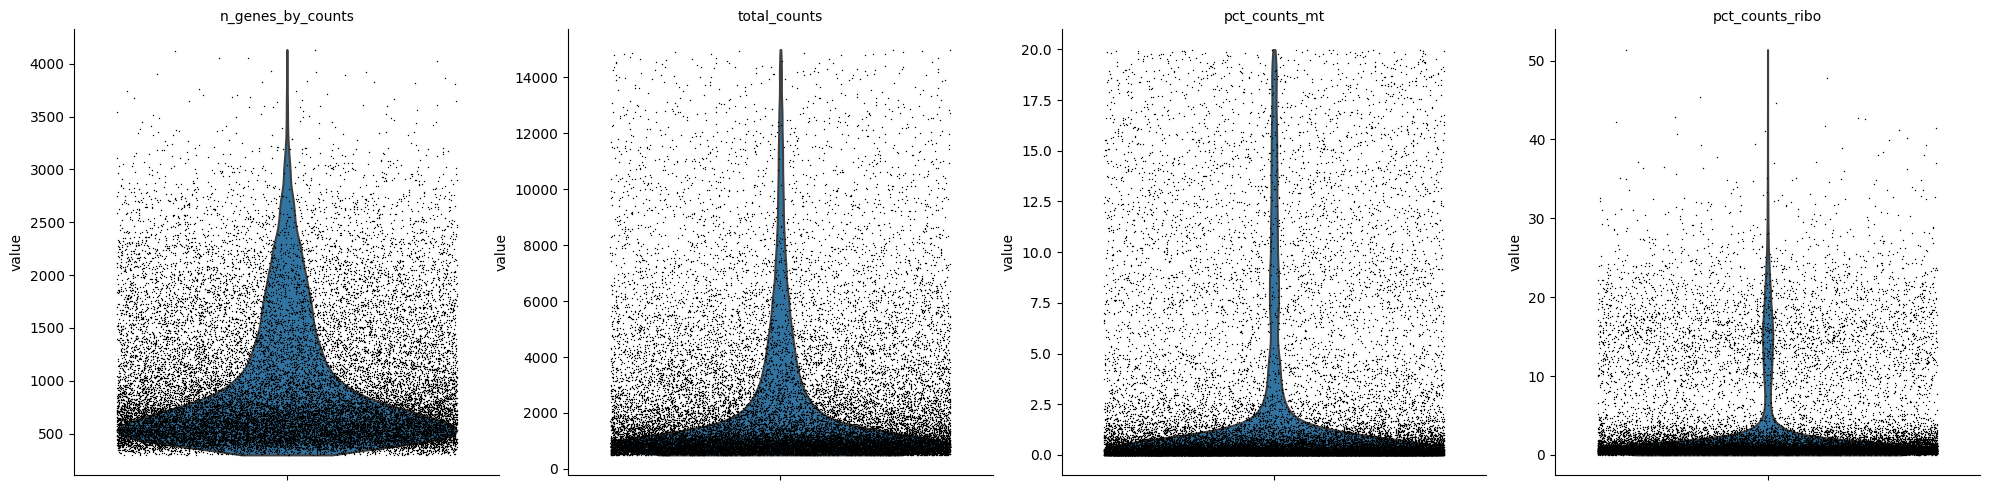

In [55]:
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo"], percent_top=None, log1p=False, inplace=True
)
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt", "pct_counts_ribo"],
    jitter=0.4,
    multi_panel=True,
)

Here we can see that the data has already been preprocessed quite a bit.

In [56]:
upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, 0.98)
adata = adata[adata.obs.n_genes_by_counts < upper_lim]
adata = adata[adata.obs.pct_counts_ribo < 35]
adata

View of AnnData object with n_obs × n_vars = 25046 × 26097
    obs: 'sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'n_cells', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'cell_type_colors'
    obsm: 'X_pca', 'X_umap'

In [57]:
adata.obs["condition"] = "adult"
adata.obs

C:\Users\Zain\AppData\Local\Temp\ipykernel_16276\4044789965.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['condition'] = 'adult'


sample  doublet  n_genes  n_genes_by_counts  \
AAACCTGAGGTTACCT-1       D3    False      614                614   
AAACCTGCAACTGGCC-1       D3    False      667                667   
AAACCTGCAAGAGGCT-1       D3    False      925                925   
AAACCTGCATTAGCCA-1       D3    False     1180               1180   
AAACCTGGTTTGACAC-1       D3    False      953                953   
...                     ...      ...      ...                ...   
TTTGCGCGTTATCCGA-1       D3    False     1626               1625   
TTTGCGCGTTCCTCCA-1-1     D3    False     2104               2104   
TTTGCGCGTTTCCACC-1       D3    False     1024               1024   
TTTGGTTAGTTCCACA-1       D3    False     1075               1075   
TTTGGTTTCACGCGGT-1       D3    False     1071               1071   

                      total_counts  total_counts_mt  pct_counts_mt  \
AAACCTGAGGTTACCT-1           971.0              3.0       0.308960   
AAACCTGCAACTGGCC-1          1072.0              3.0       0.279851   
AAACCTGCAAGAGGCT-1          1466.0             12.0       0.818554   
AAACCTGCATTAGCCA-1          1945.0              0.0       0.000000   
AAACCTGGTTTGACAC-1          1419.0              9.0       0.634250   
...                            ...              ...            ...   
TTTGCGCGTTATCCGA-1          4934.0            591.0      11.978111   
TTTGCGCGTTCCTCCA-1-1        6899.0            439.0       6.363241   
TTTGCGCGTTTCCACC-1          2406.0            286.0      11.886950   
TTTGGTTAGTTCCACA-1          2468.0            396.0      16.045382   
TTTGGTTTCACGCGGT-1          3472.0            449.0      12.932028   

                      total_counts_ribo  pct_counts_ribo condition  
AAACCTGAGGTTACCT-1                  5.0         0.514933     adult  
AAACCTGCAACTGGCC-1                  5.0         0.466418     adult  
AAACCTGCAAGAGGCT-1                 14.0         0.954980     adult  
AAACCTGCATTAGCCA-1                 13.0         0.668380     adult  
AAACCTGGTTTGACAC-1                 11.0         0.775194     adult  
...                                 ...              ...       ...  
TTTGCGCGTTATCCGA-1                720.0        14.592622     adult  
TTTGCGCGTTCCTCCA-1-1             1107.0        16.045805     adult  
TTTGCGCGTTTCCACC-1                520.0        21.612635     adult  
TTTGGTTAGTTCCACA-1                223.0         9.035657     adult  
TTTGGTTTCACGCGGT-1                557.0        16.042627     adult  

[25046 rows x 10 columns]

In [ ]:
adata.write_h5ad("adata_adult_final.h5ad")

### Combine both samples

Finally, we can combine both of the samples together (adult, fetal)

In [3]:
bdata = sc.read_h5ad("adata_foetal_final.h5ad")
cdata = sc.read_h5ad("adata_adult_final.h5ad")

In [4]:
bdata

AnnData object with n_obs × n_vars = 19350 × 19720
    obs: 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'sample', 'condition'

In [5]:
cdata

AnnData object with n_obs × n_vars = 25046 × 26097
    obs: 'sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'condition'
    var: 'n_cells', 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'cell_type_colors'
    obsm: 'X_pca', 'X_umap'

In [6]:
adata = sc.concat([cdata, bdata], join="outer")
adata

e:\BIOINFO\.venv\Lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 44396 × 28039
    obs: 'sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'condition'
    obsm: 'X_pca', 'X_umap'

We ended up with **44,396** cells and **28,039** genes. 

In [8]:
adata.write_h5ad("combined_final.h5ad")

### Normalization

Before we can do the final integration of our samples, we need to perform **Normalization**. <br/> Normalization removes technical biases and makes genes comparable across cells, so that only true biological variation is left.

In [4]:
adata = sc.read_h5ad("combined_final.h5ad")
adata

e:\BIOINFO\.venv\Lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 44396 × 28039
    obs: 'sample', 'doublet', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'condition'
    obsm: 'X_pca', 'X_umap'

In [5]:
adata.obs_names_make_unique()

It is best if we save the raw data in case we need it. I'm going to save it in ```counts``` layer of the ```adata``` object.

In [6]:
adata.layers["counts"] = adata.X.copy()

In [7]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata.raw = adata

Now we can begin the actual integration. I'm going to use ```scvi-tools``` again to perform the integration. First, we need to setup our ```scvi model``` based on the following parameters: <br/> 
For ```categorical_covariate_keys``` I am going to pass the ```'samples'``` column. <br/>
And for ```continuous_covariate_keys```: ```'pct_counts_mt', 'total_counts', 'pct_counts_ribo'``` columns. 

In [10]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    categorical_covariate_keys=["sample"],
    continuous_covariate_keys=["pct_counts_mt", "total_counts", "pct_counts_ribo"],
)

In [11]:
model = scvi.model.SCVI(adata)

Next, we need to train the ```model```. 

In [28]:
model.train()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 180/180: 100%|██████████| 180/180 [14:34<00:00,  4.98s/it, v_num=1, train_loss_step=4.33e+3, train_loss_epoch=3.8e+3] 

`Trainer.fit` stopped: `max_epochs=180` reached.


Epoch 180/180: 100%|██████████| 180/180 [14:34<00:00,  4.86s/it, v_num=1, train_loss_step=4.33e+3, train_loss_epoch=3.8e+3]


In [39]:
model.save("scvi_model_heart.model.model")  # Save the model in case we need it again.

Once the model is trained, we can get a couple of important things. First, I'm going to save the ```latent_representation``` as a layer in our ```adata``` object. We will use this layer to perform clustering and UMAP.

In [9]:
adata.obsm["X_scVI"] = model.get_latent_representation()

Second, we can call the ```get_normalized_expression```, which basically returns a cell x gene dataframe but with normalized gene expression. Let's also save this as a seperate layer in our ```adata``` object. 

In [10]:
adata.layers["scvi_normalized"] = model.get_normalized_expression(library_size=1e4)

# h. Clustering
To Cluster our data I am going to use scanpy's neighbors function, which is going to compute a neighborhood graph of observations (cells) in our dataset. The ```use_rep = 'X_scVI'``` parameter makes sure that we are using the latent representation from SCVI that we saved before. 

In [11]:
sc.pp.neighbors(adata, use_rep="X_scVI")

e:\BIOINFO\.venv\Lib\site-packages\umap\distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
e:\BIOINFO\.venv\Lib\site-packages\umap\distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
e:\BIOINFO\.venv\Lib\site-packages\umap\distances.py:1086: NumbaDeprecationWarning: The 'nopython' keyword argument was not supp

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


In [12]:
sc.tl.umap(adata)  # Calculate the UMAP

In [72]:
sc.tl.leiden(adata, resolution=1)  # Calculate the leiden clusters

e:\BIOINFO\.venv\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
e:\BIOINFO\.venv\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


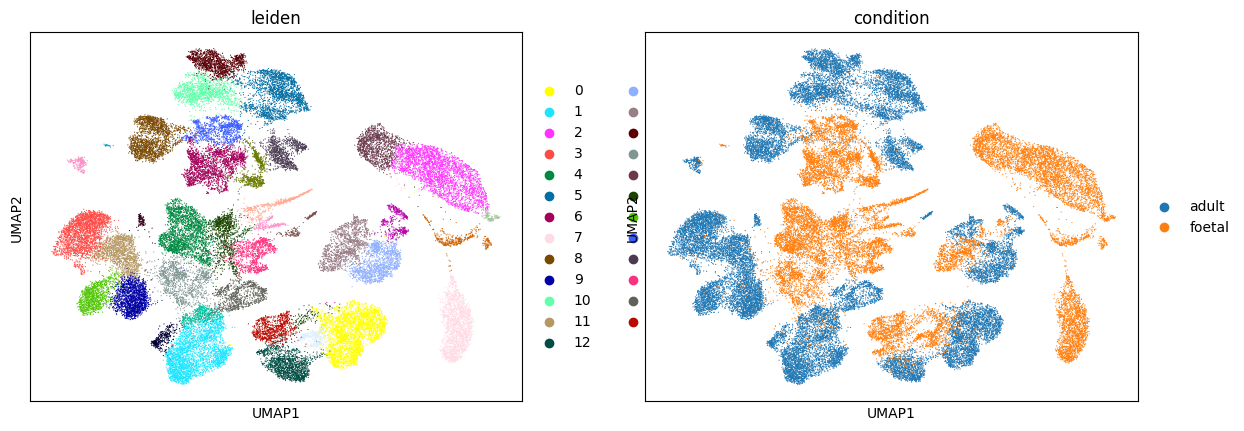

In [73]:
sc.pl.umap(adata, color=["leiden", "condition"])  # Plot the UMAP

Since we went with a higher resolution to calculate the leiden clusters, we ended up with **36 different clusters**. But this also allowed us to capture and retain minor cell populations that could have been overlooked with a lower resolution. Most of the other clusters are going to get grouped into similar cell types in the next step. <br/>

# i. Finding Markers and Labelling cell types

The next step is to find the cell type markers, and labelling the leiden clusters. Let's start by ranking the different genes inside each cluster. 

e:\BIOINFO\.venv\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:394: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'names'] = self.var_names[global_indices]
e:\BIOINFO\.venv\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:396: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'scores'] = scores[global_indices]
e:\BIOINFO\.venv\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:399: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `fr

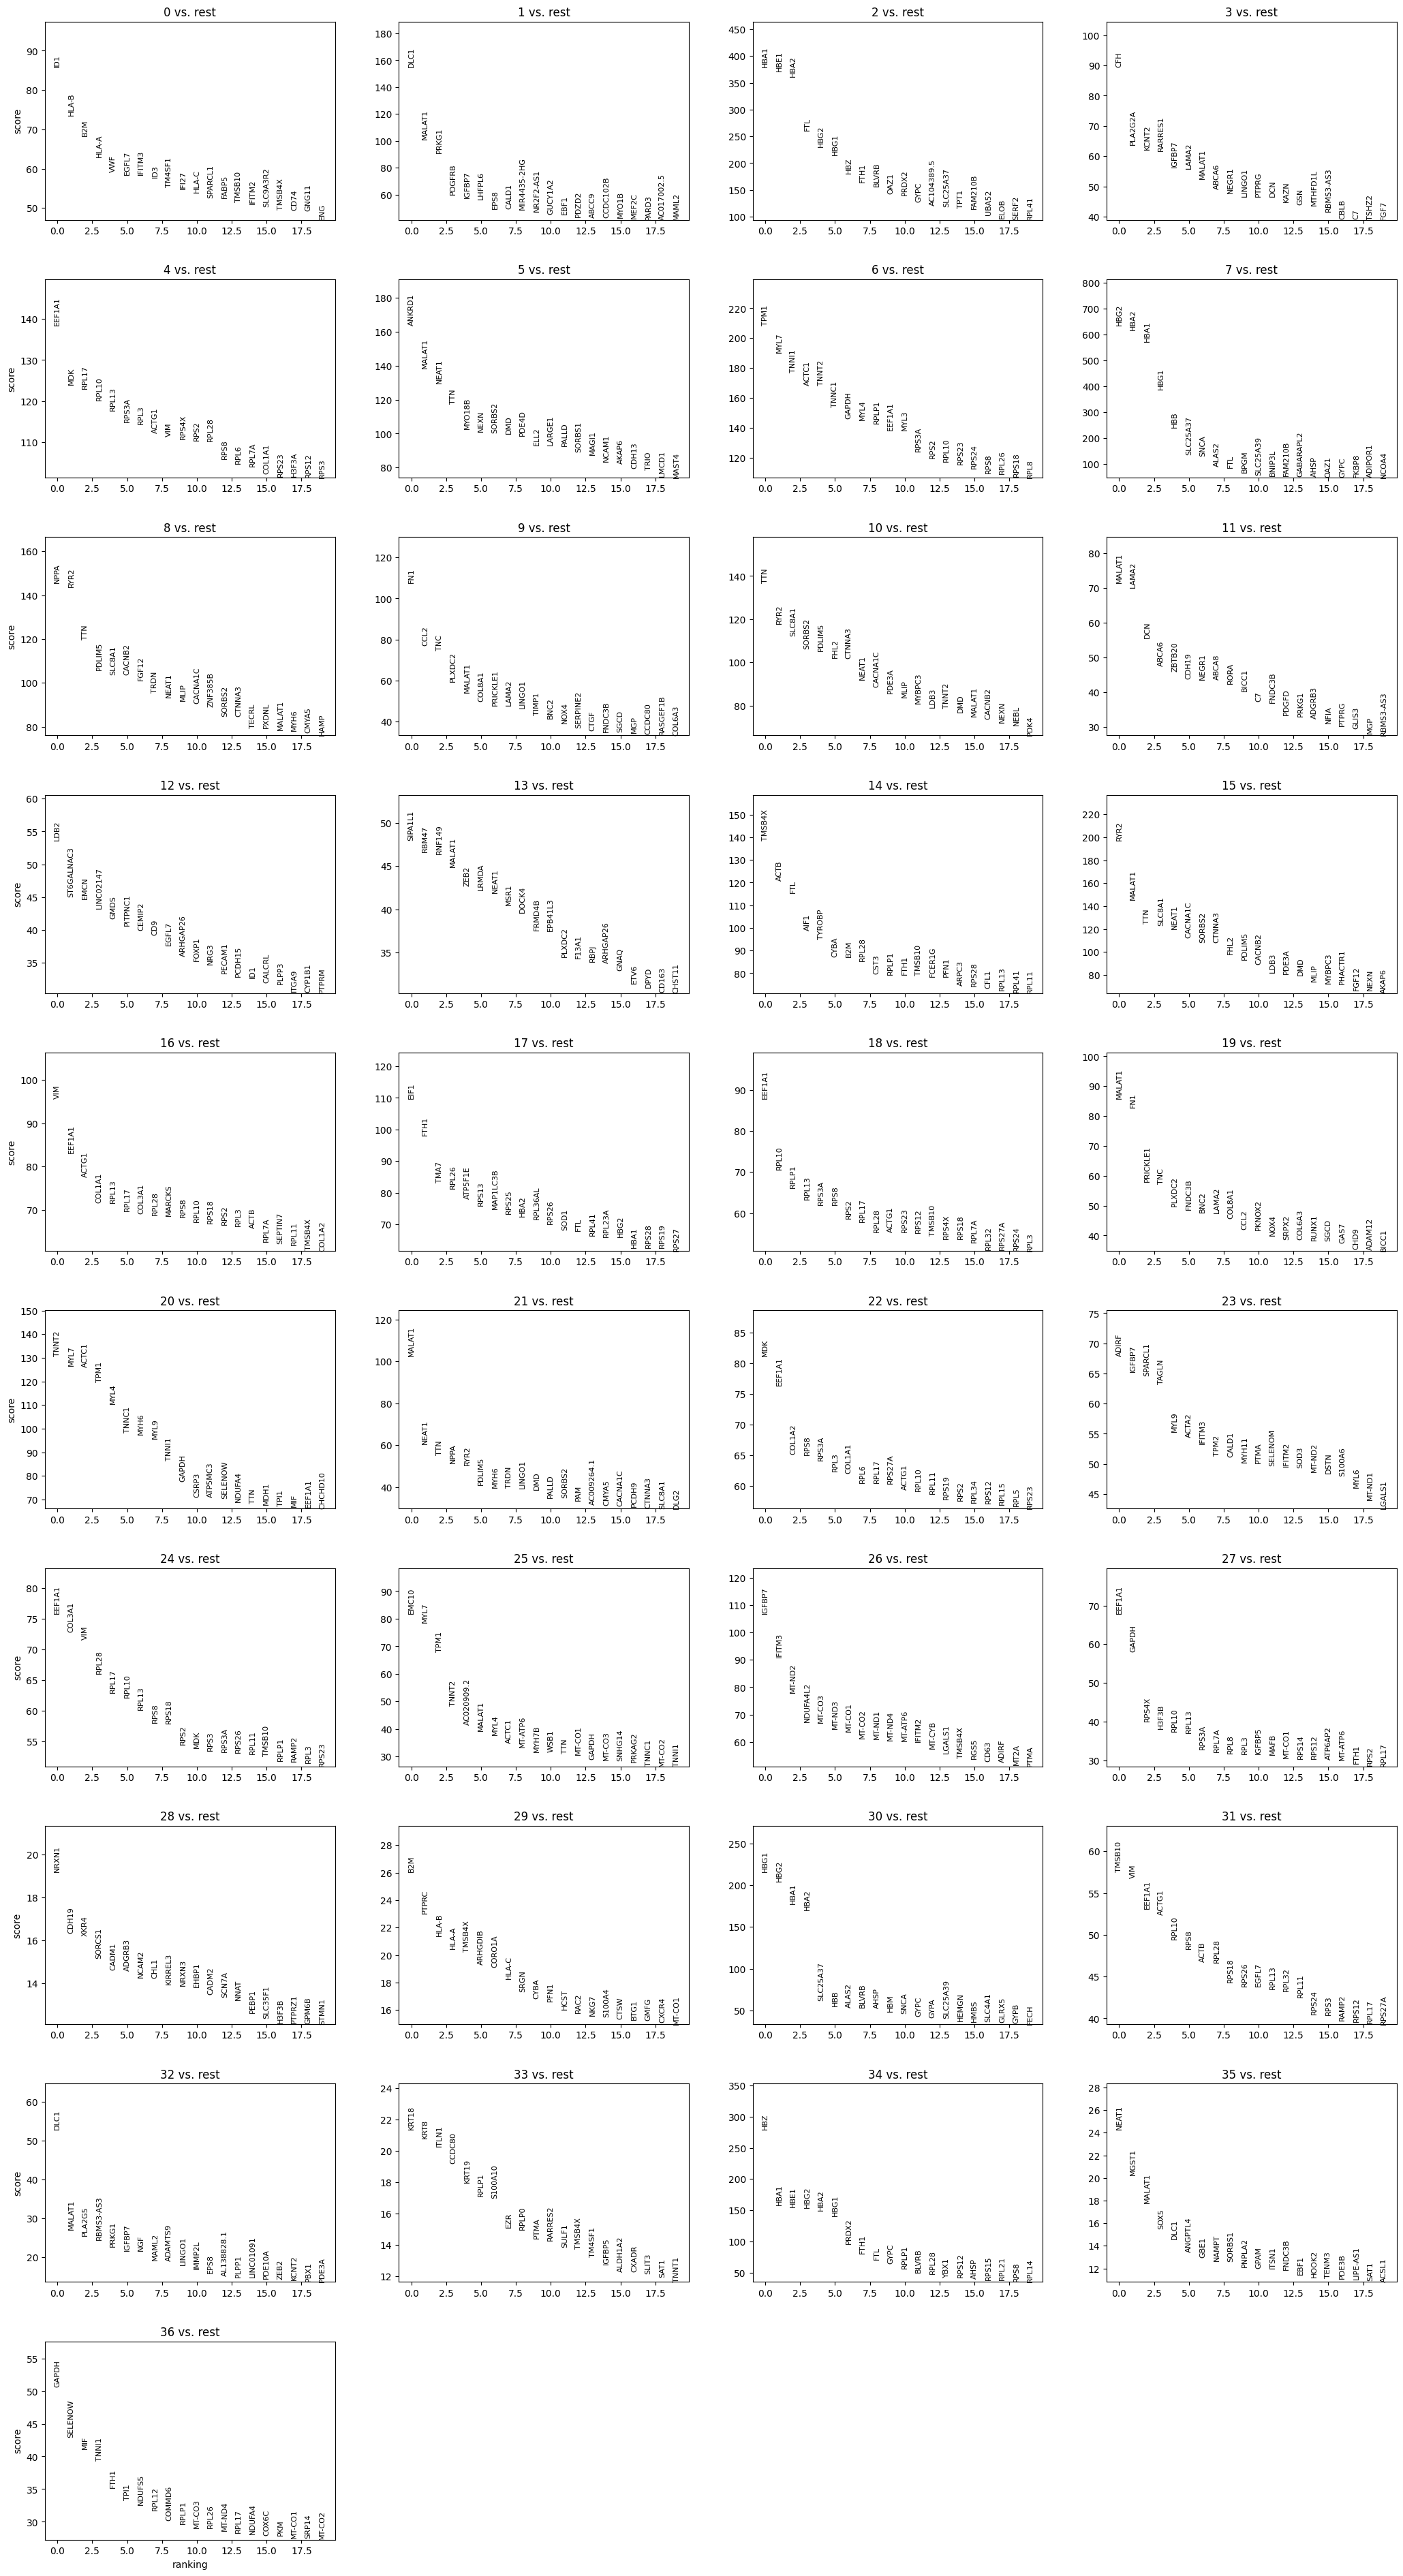

In [74]:
sc.tl.rank_genes_groups(adata, "leiden")
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

Here we can see the top 20 genes inside each leiden cluster. <br/>
A much more practical way would be to get a dataframe of the ranked gene groups and filter it based on the ```pValue``` and ```LogFoldChange```. 

In [75]:
markers = sc.get.rank_genes_groups_df(adata, None)
markers = markers[(markers.pvals_adj < 0.05) & (markers.logfoldchanges > 0.5)]

Now we can call this ```markers``` dataframe whenever we want to see which genes are in which cluster. Let's go ahead and plot the UMAP again but this time with the group number on the clusters so we know exactly what we are working with. 

e:\BIOINFO\.venv\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
e:\BIOINFO\.venv\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


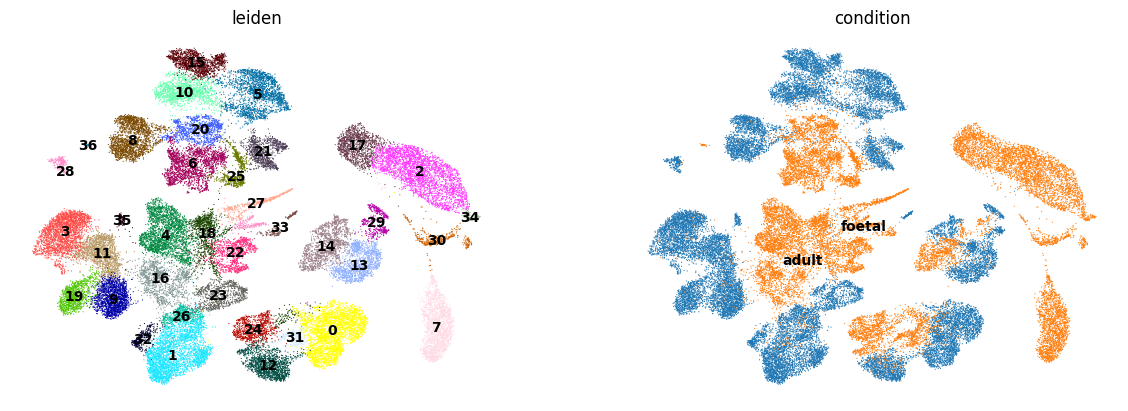

In [76]:
sc.pl.umap(adata, color=["leiden", "condition"], frameon=False, legend_loc="on data")

For labelling cell types, I went with the following methods: <br/>
- Using known canonical markers from research papers, and sites like [panglaodb](https://panglaodb.se/markers.html?cell_type=%27choose%27) (Preferred)
- Using the top ranked genes in each cluster and searching their expression in cell types that are known to be in our dataset.
- Passing the list of genes in each cluster to Enrichr / DAVID to get a list of pathways the genes are involved in. This can allow us to guess the cell types based on the enriched pathways.

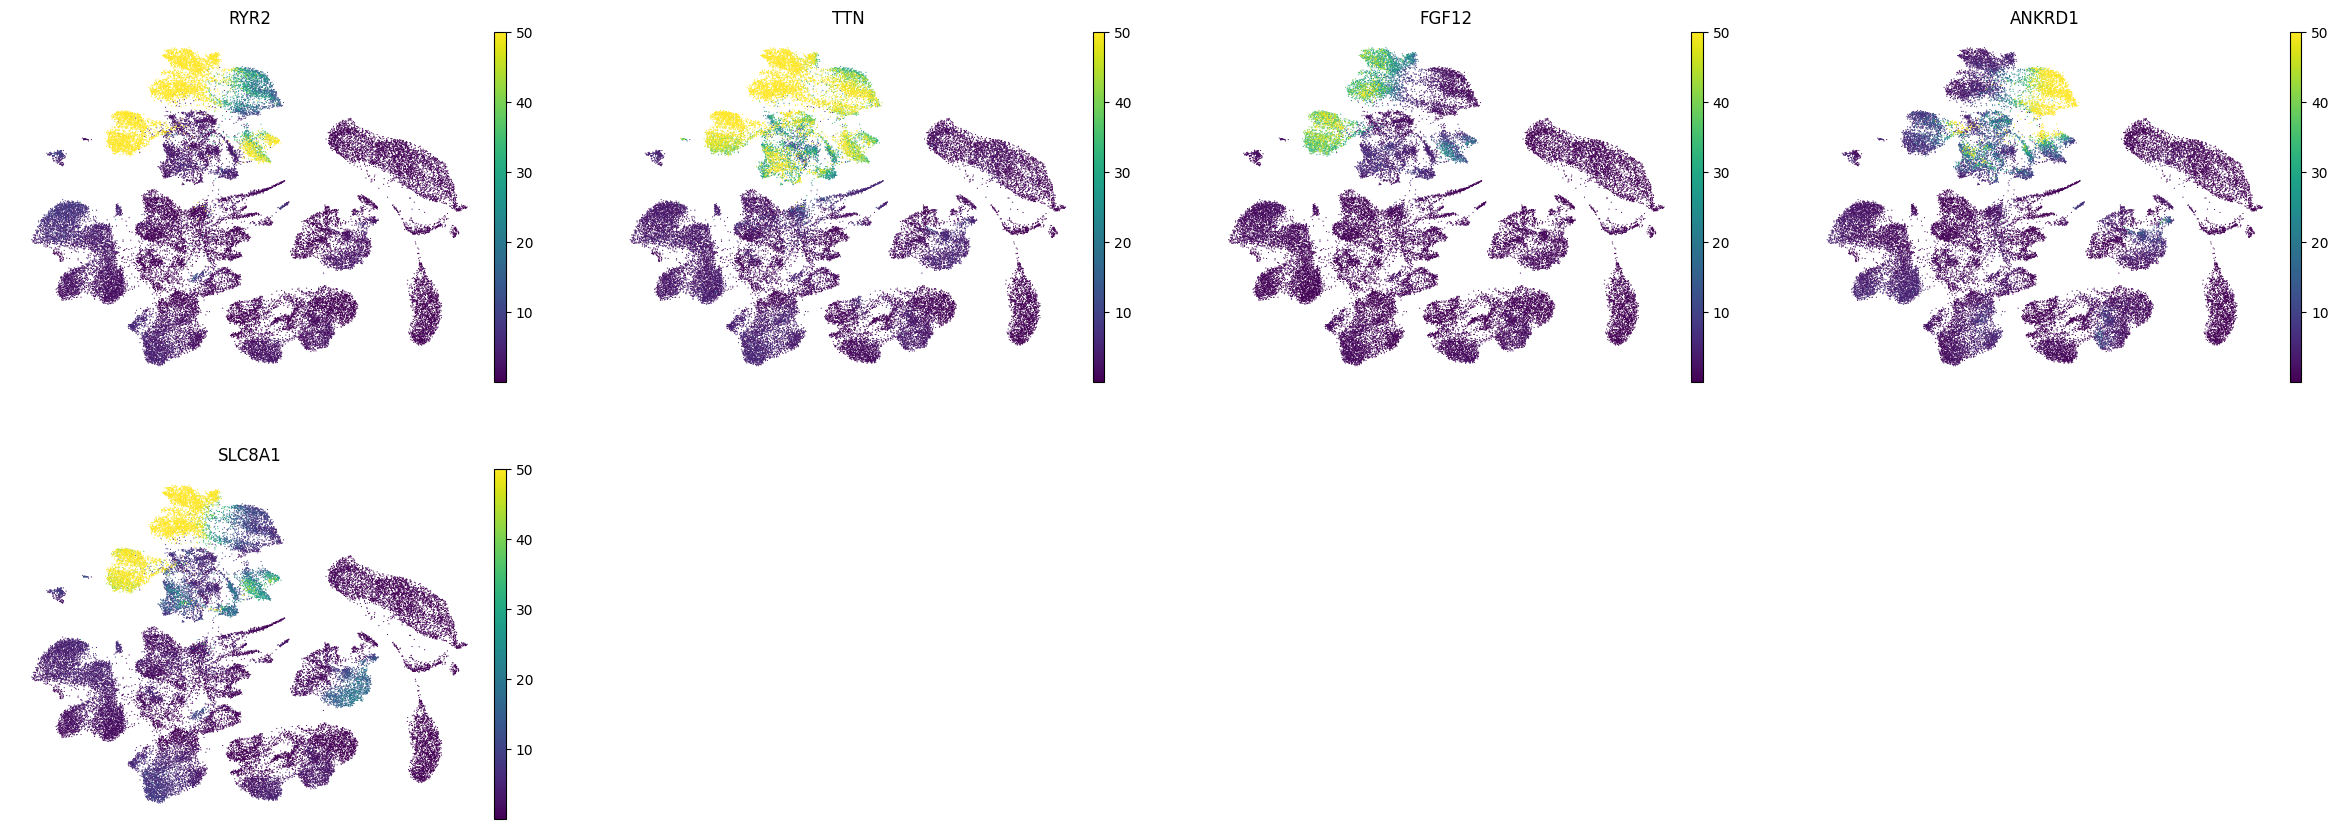

In [191]:
sc.pl.umap(
    adata,
    color=["RYR2", "TTN", "FGF12", "ANKRD1", "SLC8A1"],
    frameon=False,
    layer="scvi_normalized",
    vmax=50,
)

Here, I've plotted the major genes that are known to be expressed by **mature cardiomyocytes**. We can see that clusters 8, 10, 15, 5 and 21 all show expression of these genes. This can also be confirmed by searching for the genes in the ```markers``` dataframe. 

In [192]:
markers[markers.names == "RYR2"]

group names      scores  logfoldchanges          pvals      pvals_adj
140231     5  RYR2   61.877094        2.473717   0.000000e+00   0.000000e+00
224313     8  RYR2  143.740051        4.948493   0.000000e+00   0.000000e+00
280391    10  RYR2  117.951431        4.998883   0.000000e+00   0.000000e+00
420585    15  RYR2  197.003860        5.257217   0.000000e+00   0.000000e+00
588823    21  RYR2   50.519081        3.344584  1.178653e-274  1.251827e-272

In [195]:
markers[markers.group == "10"][:10]

group    names      scores  logfoldchanges  pvals  pvals_adj
280390    10      TTN  136.822006        4.322868    0.0        0.0
280391    10     RYR2  117.951431        4.998883    0.0        0.0
280392    10   SLC8A1  112.200394        4.505400    0.0        0.0
280393    10   SORBS2  106.105751        3.988508    0.0        0.0
280394    10   PDLIM5  105.371552        3.899891    0.0        0.0
280395    10     FHL2  102.208923        4.533942    0.0        0.0
280396    10   CTNNA3  101.824608        4.660658    0.0        0.0
280397    10    NEAT1   92.174400        3.055995    0.0        0.0
280398    10  CACNA1C   88.642044        3.721264    0.0        0.0
280399    10    PDE3A   85.743256        3.611465    0.0        0.0

Similarly, I've labelled all of the 36 clusters with the different (or same) cell types. 

In [7]:
cell_types = {
    "0": "Endothelial: Venous Cells",
    "1": "Pericytes",
    "2": "Erythrocytes",
    "3": "Cardiac Fibroblasts",
    "4": "Cardiac Fibroblasts",
    "5": "Cardiomyocytes",
    "6": "Immature Cardiomyocytes",
    "7": "Erythroid-like / erythroid precursor cells",
    "8": "Cardiomyocytes",
    "9": "Cardiac Fibroblasts",
    "10": "Cardiomyocytes",
    "11": "Cardiac Fibroblasts",
    "12": "Other Endothelial Cells",
    "13": "Other Immune Cells",
    "14": "Macrophages",
    "15": "Cardiomyocytes",
    "16": "Cardiac Fibroblasts",
    "17": "Reticulocytes",
    "18": "Cardiac Fibroblasts",
    "19": "Cardiac Fibroblasts",
    "20": "Immature Cardiomyocytes",
    "21": "Cardiomyocytes",
    "22": "Cardiac Fibroblasts",
    "23": "Smooth Muscle Cells",
    "24": "Endocardial Cells",
    "25": "Immature Cardiomyocytes",
    "26": "Pericytes: Stromal",
    "27": "Cardiac Fibroblasts",
    "28": "Neuronal Cells",
    "29": "Lymphoid Cells",
    "30": "Erythroblasts",
    "31": "Endothelial: Arterial Cells",
    "32": "Pericytes",
    "33": "Epicardium: Mesothelial cells",
    "34": "Erythrocytes",
    "35": "Cardiac Fibroblasts",
    "36": "Adipocytes",
}

In [8]:
adata.obs["cell_type"] = adata.obs.leiden.map(cell_types)
adata.obs

sample  doublet  n_genes  n_genes_by_counts  total_counts  \
AAACCTGAGGTTACCT-1     D3    False      614                614         971.0   
AAACCTGCAACTGGCC-1     D3    False      667                667        1072.0   
AAACCTGCAAGAGGCT-1     D3    False      925                925        1466.0   
AAACCTGCATTAGCCA-1     D3    False     1180               1180        1945.0   
AAACCTGGTTTGACAC-1     D3    False      953                953        1419.0   
...                   ...      ...      ...                ...           ...   
TTTGGTTAGTTCTCTT-1     F2    False      234                234        6313.0   
TTTGGTTCAATTGTGC-1     F2    False      176                176        3482.0   
TTTGTTGAGAAGCCTG-1     F2    False     1000               1000        3465.0   
TTTGTTGAGGCTTAAA-1     F2    False     2159               2155        4885.0   
TTTGTTGAGTGGTGAC-1     F2    False     2954               2951       10796.0   

                    total_counts_mt  pct_counts_mt  total_counts_ribo  \
AAACCTGAGGTTACCT-1              3.0       0.308960                5.0   
AAACCTGCAACTGGCC-1              3.0       0.279851                5.0   
AAACCTGCAAGAGGCT-1             12.0       0.818554               14.0   
AAACCTGCATTAGCCA-1              0.0       0.000000               13.0   
AAACCTGGTTTGACAC-1              9.0       0.634250               11.0   
...                             ...            ...                ...   
TTTGGTTAGTTCTCTT-1              0.0       0.000000               39.0   
TTTGGTTCAATTGTGC-1              7.0       0.201034               66.0   
TTTGTTGAGAAGCCTG-1              5.0       0.144300             1194.0   
TTTGTTGAGGCTTAAA-1            182.0       3.725691              381.0   
TTTGTTGAGTGGTGAC-1            308.0       2.852909             1883.0   

                    pct_counts_ribo condition  _scvi_batch  _scvi_labels  \
AAACCTGAGGTTACCT-1         0.514933     adult            0             0   
AAACCTGCAACTGGCC-1         0.466418     adult            0             0   
AAACCTGCAAGAGGCT-1         0.954980     adult            0             0   
AAACCTGCATTAGCCA-1         0.668380     adult            0             0   
AAACCTGGTTTGACAC-1         0.775194     adult            0             0   
...                             ...       ...          ...           ...   
TTTGGTTAGTTCTCTT-1         0.617773    foetal            0             0   
TTTGGTTCAATTGTGC-1         1.895462    foetal            0             0   
TTTGTTGAGAAGCCTG-1        34.458878    foetal            0             0   
TTTGTTGAGGCTTAAA-1         7.799386    foetal            0             0   
TTTGTTGAGTGGTGAC-1        17.441645    foetal            0             0   

                   leiden  _scvi_raw_norm_scaling  \
AAACCTGAGGTTACCT-1     13               10.298661   
AAACCTGCAACTGGCC-1      0                9.328358   
AAACCTGCAAGAGGCT-1     19                6.821282   
AAACCTGCATTAGCCA-1     19                5.141388   
AAACCTGGTTTGACAC-1      0                7.047216   
...                   ...                     ...   
TTTGGTTAGTTCTCTT-1      7                1.584284   
TTTGGTTCAATTGTGC-1      7                2.871913   
TTTGTTGAGAAGCCTG-1      2                2.892682   
TTTGTTGAGGCTTAAA-1      3                2.050861   
TTTGTTGAGTGGTGAC-1     14                0.927472   

                                                     cell_type  
AAACCTGAGGTTACCT-1                          Other Immune Cells  
AAACCTGCAACTGGCC-1                   Endothelial: Venous Cells  
AAACCTGCAAGAGGCT-1                         Cardiac Fibroblasts  
AAACCTGCATTAGCCA-1                         Cardiac Fibroblasts  
AAACCTGGTTTGACAC-1                   Endothelial: Venous Cells  
...                                                        ...  
TTTGGTTAGTTCTCTT-1  Erythroid-like / erythroid precursor cells  
TTTGGTTCAATTGTGC-1  Erythroid-like / erythroid precursor cells  
TTTGTTGAGAAGCCTG-1                            

Now we can plot the ```cell_type``` column that we've added to our ```adata```. 

e:\BIOINFO\.venv\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


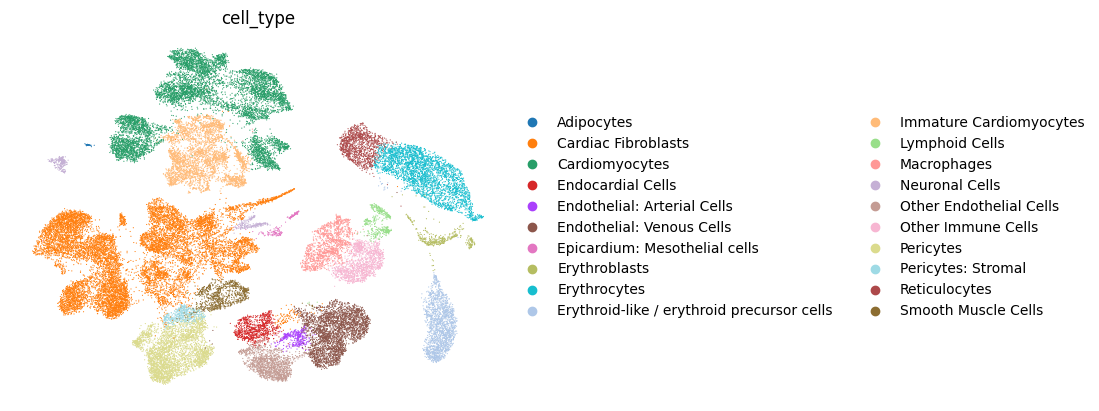

In [9]:
sc.pl.umap(adata, color=["cell_type"], frameon=False)

***Nice***

In [189]:
adata.write_h5ad("int_final.h5ad")

# j. Differential Expression
Differential expression is the analysis of gene expression changes between different conditions, e.g., cell types, and it is important for identifying genes and pathways that are associated with specific biological processes or phenotypes. <br/>
The two cell types that we are interested in comparing are **Cardiomyocytes** and **Immature Cardiomyocytes**. <br/>
We can simply use our SCVI model that we trained earlier to perform DE between these two cell types. 

In [4]:
adata = sc.read_h5ad("int_final.h5ad")

In [10]:
model = scvi.model.SCVI.load("scvi_model_heart.model", adata)

INFO     File scvi_model_heart.model\model.pt already downloaded                                                   


In [11]:
subset = adata[
    adata.obs["cell_type"].isin(["Immature Cardiomyocytes", "Cardiomyocytes"])
].copy()  # We will use this subset for plotting the heatmap later

In [12]:
de_df = model.differential_expression(
    idx1=[adata.obs["cell_type"] == "Immature Cardiomyocytes"],
    idx2=[adata.obs["cell_type"] == "Cardiomyocytes"],
)

DE...: 100%|██████████| 1/1 [01:02<00:00, 62.26s/it]


In [13]:
de_df

proba_de  proba_not_de  bayes_factor        scale1        scale2  \
GRXCR2        0.9982        0.0018      6.318161  2.711075e-06  1.882281e-04   
AC092376.1    0.9980        0.0020      6.212601  6.652367e-08  1.122638e-06   
POTEJ         0.9980        0.0020      6.212601  4.337293e-06  4.791686e-05   
AL110292.1    0.9980        0.0020      6.212601  1.678181e-06  1.075877e-04   
PRND          0.9978        0.0022      6.117091  4.613653e-06  1.786320e-07   
...              ...           ...           ...           ...           ...   
AP2A1         0.5714        0.4286      0.287565  3.669429e-05  3.304226e-05   
ECHDC1        0.5666        0.4334      0.267992  3.856737e-05  3.521946e-05   
RAD23B        0.5614        0.4386      0.246846  5.868058e-05  6.012319e-05   
SH3GLB1       0.5438        0.4562      0.175650  9.371457e-05  8.046015e-05   
SMAP1         0.5432        0.4568      0.173232  6.142324e-05  6.520648e-05   

            pseudocounts  delta  lfc_mean  lfc_median   lfc_std    lfc_min  \
GRXCR2               0.0   0.25 -9.227058   -9.287463  3.728964 -23.587013   
AC092376.1           0.0   0.25 -4.753747   -4.768054  1.777045 -12.501547   
POTEJ                0.0   0.25 -6.819905   -6.911525  2.820899 -17.269550   
AL110292.1           0.0   0.25 -6.595656   -6.679956  2.262949 -13.463219   
PRND                 0.0   0.25  6.259858    6.361467  2.456181  -4.869413   
...                  ...    ...       ...         ...       ...        ...   
AP2A1                0.0   0.25  0.140573    0.138375  0.441458  -1.513621   
ECHDC1               0.0   0.25  0.150482    0.125533  0.430455  -1.481397   
RAD23B               0.0   0.25 -0.041684   -0.029386  0.457682  -2.237763   
SH3GLB1              0.0   0.25  0.188620    0.156250  0.421833  -1.536223   
SMAP1                0.0   0.25 -0.104647   -0.092140  0.399997  -1.469398   

              lfc_max  raw_mean1  raw_mean2  non_zeros_proportion1  \
GRXCR2       5.476413   0.002527   0.338582               0.002527   
AC092376.1   3.566935   0.000000   0.002514               0.000000   
POTEJ        6.325583   0.004212   0.059407               0.002808   
AL110292.1   4.852039   0.000842   0.042604               0.000842   
PRND        13.397240   0.003089   0.000132               0.002808   
...               ...        ...        ...                    ...   
AP2A1        1.952185   0.320981   0.088383               0.235889   
ECHDC1       2.143091   0.392029   0.122651               0.276327   
RAD23B       2.386866   0.554344   0.213678               0.355237   
SH3GLB1      2.161352   0.829265   0.274674               0.431059   
SMAP1        1.371563   0.598992   0.201903               0.362539   

            non_zeros_proportion2  raw_normalized_mean1  raw_normalized_mean2  \
GRXCR2                   0.180868              0.011187              1.406911   
AC092376.1               0.002514              0.000000              0.006075   
POTEJ                    0.044985              0.021168              0.255200   
AL110292.1               0.019185              0.004017              0.114949   
PRND                     0.000132              0.019676              0.002107   
...                           ...                   ...                   ...   
AP2A1                    0.080445              0.350123              0.285404   
ECHDC1                   0.108627              0.400182              0.377440   
RAD23B                   0.174782              0.621883              0.621742   
SH3GLB1                  0.212622              0.883370              0.793473   
SMAP1                    0.169092              0.609734              0.628081   

            is_de_fdr_0.05  
GRXCR2                True  
AC092376.1            True  
POTEJ                 True  
AL110292.1            True  
PRND                  True  
...                    ...  
AP2A1                False  
ECHDC1               False  
RAD23B               False  
SH3GLB1   

Next, we need to filter this dataframe to only keep the most differentially expressed genes. 

In [15]:
de_df = de_df[(de_df["is_de_fdr_0.05"]) & (abs(de_df.lfc_mean) > 0.5)]
de_df = de_df[(de_df.raw_normalized_mean1 > 0.5) | (de_df.raw_normalized_mean2 > 0.5)]
de_df = de_df.sort_values("lfc_mean")
de_df

proba_de  proba_not_de  bayes_factor    scale1        scale2  \
AP000462.1    0.9938        0.0062      5.076985  0.000004  1.156082e-04   
LINC02147     0.9946        0.0054      5.215940  0.000005  2.832826e-04   
GRXCR2        0.9982        0.0018      6.318161  0.000003  1.882281e-04   
LINC02398     0.9976        0.0024      6.029880  0.000001  6.274124e-05   
C12orf40      0.9942        0.0058      5.144079  0.000002  6.656993e-05   
...              ...           ...           ...       ...           ...   
STMN1         0.9958        0.0042      5.468460  0.000708  1.167009e-05   
DBNDD2        0.9944        0.0056      5.179371  0.000069  1.286814e-06   
TNNI1         0.9956        0.0044      5.421739  0.003979  5.876126e-05   
BEX1          0.9952        0.0048      5.334326  0.000104  1.891231e-06   
TRH           0.9974        0.0026      5.949637  0.000040  7.648474e-07   

            pseudocounts  delta   lfc_mean  lfc_median   lfc_std    lfc_min  \
AP000462.1           0.0   0.25  -9.548100  -10.072870  3.130112 -18.010357   
LINC02147            0.0   0.25  -9.426950   -9.454157  4.122445 -23.144489   
GRXCR2               0.0   0.25  -9.227058   -9.287463  3.728964 -23.587013   
LINC02398            0.0   0.25  -9.220113   -9.682395  3.741063 -19.663349   
C12orf40             0.0   0.25  -9.030154   -9.415596  2.985489 -18.143618   
...                  ...    ...        ...         ...       ...        ...   
STMN1                0.0   0.25   7.159717    7.363700  1.969260  -3.137186   
DBNDD2               0.0   0.25   7.391666    7.707655  1.840180  -4.028177   
TNNI1                0.0   0.25   7.907197    8.274340  1.878425  -3.646535   
BEX1                 0.0   0.25   8.183931    8.495310  2.207827  -6.193480   
TRH                  0.0   0.25  10.602255   10.854321  3.073313  -6.828886   

              lfc_max  raw_mean1  raw_mean2  non_zeros_proportion1  \
AP000462.1   7.829000   0.005897   0.300742               0.005336   
LINC02147    6.766718   0.013760   0.551740               0.006178   
GRXCR2       5.476413   0.002527   0.338582               0.002527   
LINC02398    5.555395   0.000562   0.160888               0.000281   
C12orf40     7.054398   0.002527   0.248608               0.002527   
...               ...        ...        ...                    ...   
STMN1       12.610839   7.896434   0.084678               0.752598   
DBNDD2      12.870511   0.752598   0.004631               0.396237   
TNNI1       13.903456  44.258045   0.260519               0.914350   
BEX1        15.345458   0.927267   0.011511               0.353552   
TRH         19.354534   0.600395   0.003308               0.205841   

            non_zeros_proportion2  raw_normalized_mean1  raw_normalized_mean2  \
AP000462.1               0.205742              0.026290              0.921439   
LINC02147                0.261180              0.053039              2.063366   
GRXCR2                   0.180868              0.011187              1.406911   
LINC02398                0.127150              0.001901              0.590920   
C12orf40                 0.174517              0.009488              0.619762   
...                           ...                   ...                   ...   
STMN1                    0.015877              7.956129              0.132218   
DBNDD2                   0.002911              0.689776              0.008673   
TNNI1                    0.025800             40.745979              0.471426   
BEX1                     0.003572              1.054738              0.021276   
TRH                      0.001852              0.578393              0.008853   

            is_de_fdr_0.05  
AP000462.1            True  
LINC02147             True  
GRXCR2                True  
LINC02398             True  
C12orf40              True  
...                    ...  
STMN1                 True  
DBNDD2                True  
TNNI1                 True  
BEX1                  True  
TRH              

For plotting, I am only going to use the top 25 most upregulated, and top 25 most downregulated genes. 

In [ ]:
de_genes = de_df[-25:].index.tolist() + de_df[:25].index.tolist()

And finally, we can plot a heatmap of these genes. 

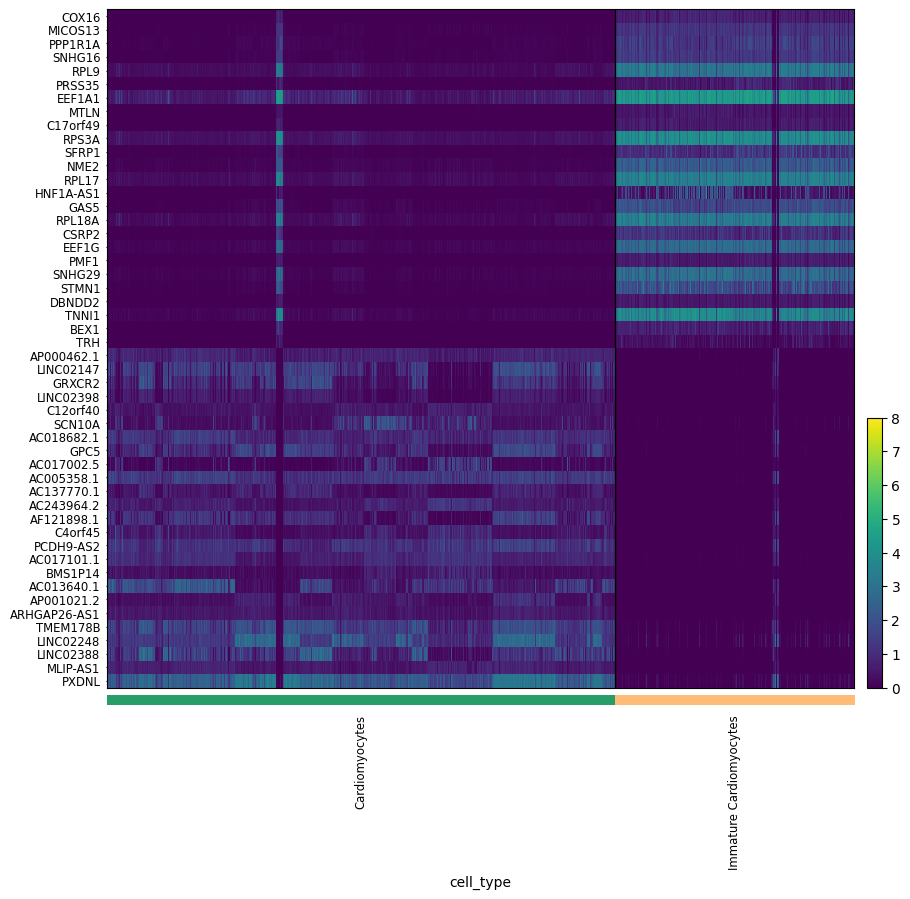

In [18]:
sc.pl.heatmap(
    subset,
    de_genes,
    groupby="cell_type",
    swap_axes=True,
    layer="scvi_normalized",
    log=True,
    show_gene_labels=True,
    vmin=0,
    vmax=8,
)

# k. Pathway Analysis
Pathway Analysis is used to determine the biological pathways that are significantly enriched in a set of genes, which can help us to gain insights into the underlying biological mechanisms. <br/>
To perform pathway analysis, I am going to use a python package called ```gseapy```. It provides an easy way to access Enrichr here in Python. 

To get a list of Enrichr libraries:

In [21]:
gp.get_library_name()

['ARCHS4_Cell-lines',
 'ARCHS4_IDG_Coexp',
 'ARCHS4_Kinases_Coexp',
 'ARCHS4_TFs_Coexp',
 'ARCHS4_Tissues',
 'Achilles_fitness_decrease',
 'Achilles_fitness_increase',
 'Aging_Perturbations_from_GEO_down',
 'Aging_Perturbations_from_GEO_up',
 'Allen_Brain_Atlas_10x_scRNA_2021',
 'Allen_Brain_Atlas_down',
 'Allen_Brain_Atlas_up',
 'Azimuth_Cell_Types_2021',
 'BioCarta_2013',
 'BioCarta_2015',
 'BioCarta_2016',
 'BioPlanet_2019',
 'BioPlex_2017',
 'CCLE_Proteomics_2020',
 'CORUM',
 'COVID-19_Related_Gene_Sets',
 'COVID-19_Related_Gene_Sets_2021',
 'Cancer_Cell_Line_Encyclopedia',
 'CellMarker_Augmented_2021',
 'ChEA_2013',
 'ChEA_2015',
 'ChEA_2016',
 'ChEA_2022',
 'Chromosome_Location',
 'Chromosome_Location_hg19',
 'ClinVar_2019',
 'DSigDB',
 'Data_Acquisition_Method_Most_Popular_Genes',
 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019',
 'DepMap_WG_CRISPR_Screens_Sanger_CellLines_2019',
 'Descartes_Cell_Types_and_Tissue_2021',
 'Diabetes_Perturbations_GEO_2022',
 'DisGeNET',
 'Disease_

Now we can simply call the Enrichr API and give it our list of top 25 upregulated genes.

In [22]:
enr = gp.enrichr(
    gene_list=de_genes[:25],
    gene_sets=[
        "Reactome_2022",
        "WikiPathways_2019_Human",
        "KEGG_2021_Human",
        "Elsevier_Pathway_Collection",
    ],
    organism="human",
    outdir=None,
    background=subset.var_names.tolist(),
)

In [23]:
enr.results

Gene_set  \
0                  Reactome_2022   
1                  Reactome_2022   
2                  Reactome_2022   
3                  Reactome_2022   
4                  Reactome_2022   
..                           ...   
140  Elsevier_Pathway_Collection   
141  Elsevier_Pathway_Collection   
142  Elsevier_Pathway_Collection   
143  Elsevier_Pathway_Collection   
144  Elsevier_Pathway_Collection   

                                                  Term       P-value  \
0       Eukaryotic Translation Elongation R-HSA-156842  1.372031e-08   
1                Peptide Chain Elongation R-HSA-156902  9.034809e-07   
2                              Translation R-HSA-72766  3.068205e-06   
3               Selenocysteine Synthesis R-HSA-2408557  6.315927e-05   
4                  Viral mRNA Translation R-HSA-192823  6.534999e-05   
..                                                 ...           ...   
140                               Prolactinoma Overiew  4.792150e-02   
141  Proteins with Altered Expression in Cancer-Ass...  5.047098e-02   
142                 Proteins Involved in Periodontitis  5.047098e-02   
143                      Proteins Involved in Glaucoma  6.730075e-02   
144  Proteins Involved in Amyotrophic Lateral Scler...  1.441763e-01   

     Adjusted P-value  Old P-value  Old adjusted P-value  Odds Ratio  \
0            0.000001            0                     0   84.129518   
1            0.000038            0                     0   66.509524   
2            0.000087            0                     0   27.107422   
3            0.000764            0                     0   45.340909   
4            0.000764            0                     0   44.805882   
..                ...          ...                   ...         ...   
140          0.055518            0                     0   21.574074   
141          0.055518            0                     0   20.436404   
142          0.055518            0                     0   20.436404   
143          0.070506            0                     0   15.117424   
144          0.144176            0                     0    6.705443   

     Combined Score                           Genes  
0       1523.113490  EEF1A1;EEF1G;RPL18A;RPS3A;RPL9  
1        925.613769        EEF1A1;RPL18A;RPS3A;RPL9  
2        344.112941  EEF1A1;EEF1G;RPL18A;RPS3A;RPL9  
3        438.439832               RPL18A;RPS3A;RPL9  
4        431.738425               RPL18A;RPS3A;RPL9  
..              ...                             ...  
140       65.546157                             TRH  
141       61.030393                           SFRP1  
142       61.030393                           SFRP1  
143       40.795638                           SFRP1  
144       12.986557                             TRH  

[145 rows x 9 columns]

This returns a dataframe that we can plot using a ```barplot```. 

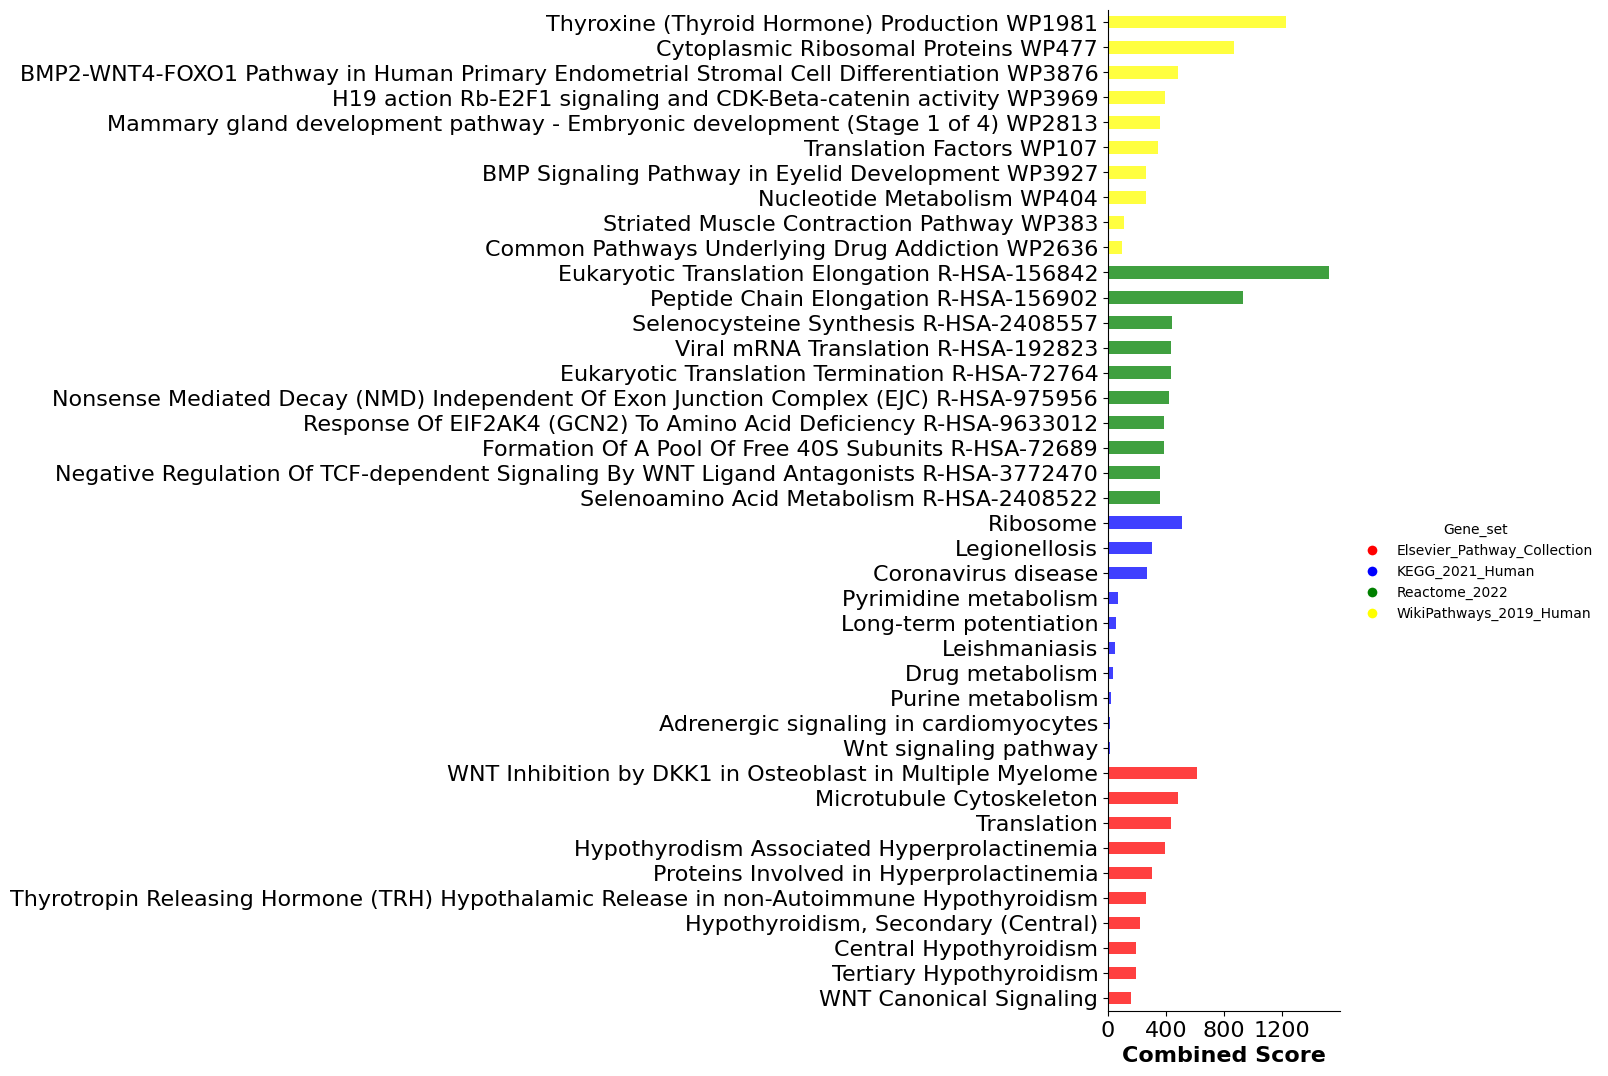

In [24]:
ax = barplot(
    enr.results,
    column="Combined Score",
    group="Gene_set",
    size=20,
    top_term=10,
    figsize=(3, 13),
    color=["red", "blue", "green", "yellow"],
)

This list may seem a bit vague at first, but there are still some useful insights we can gain from it. Some pathways might not directly relate to cardiomyocyte development, but others like thyroid hormone signaling, translation, and Wnt signaling could be relevant. Let's take a closer look at **Elsevier Pathway Collection** results. 

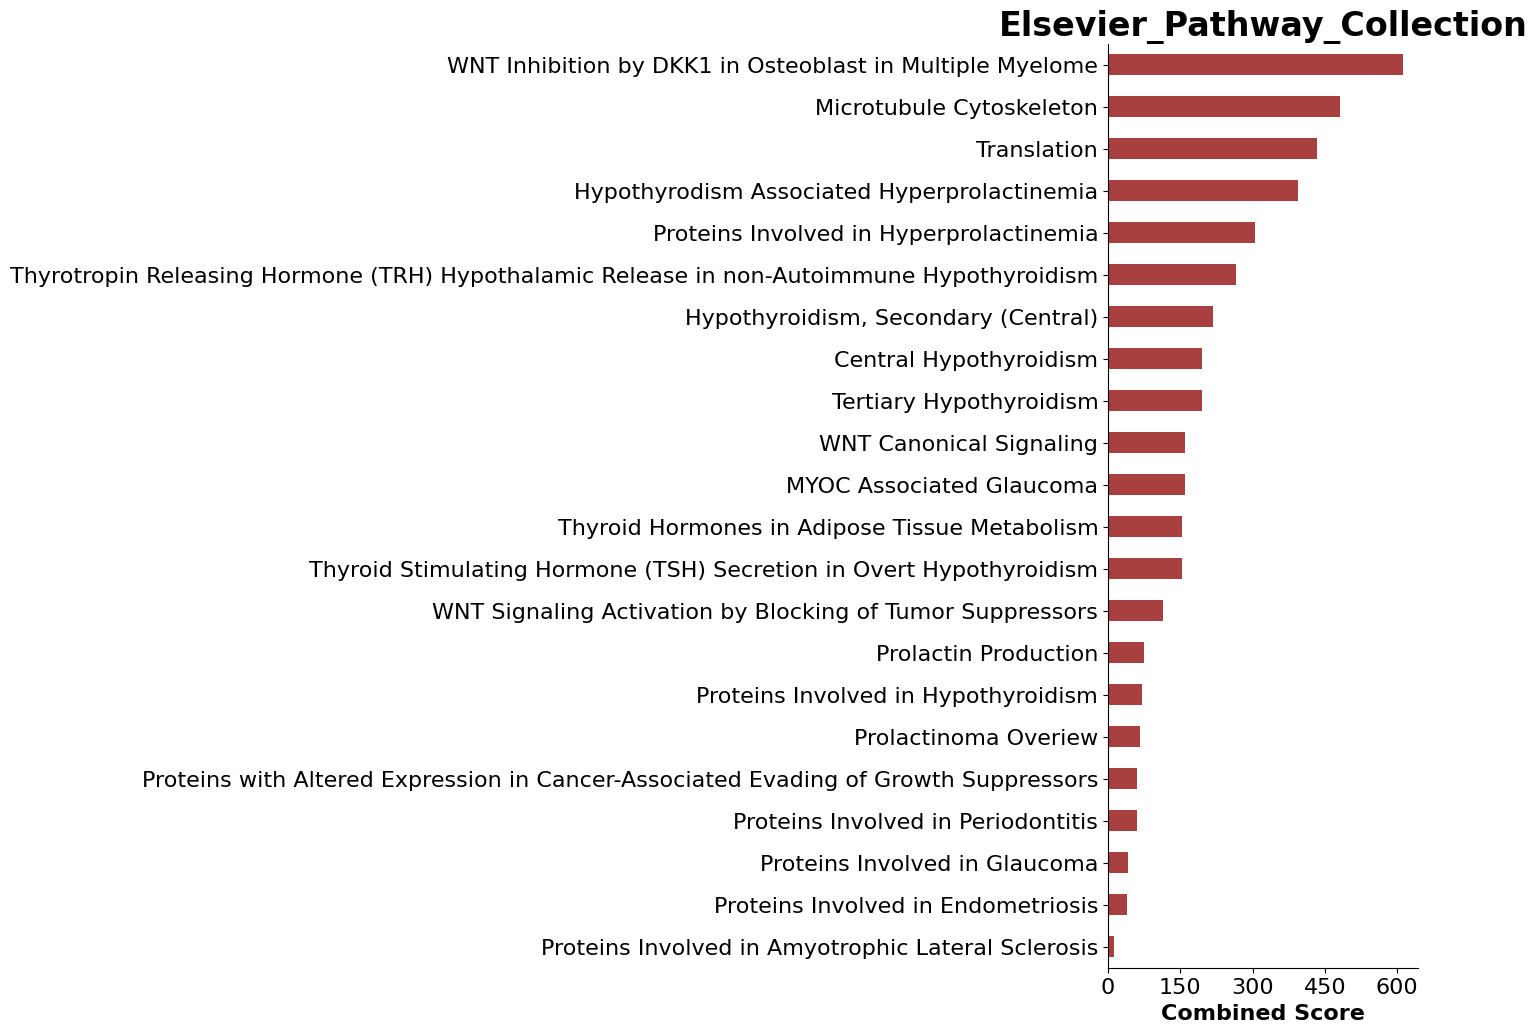

In [25]:
ax = barplot(
    enr.res2d,
    title="Elsevier_Pathway_Collection",
    figsize=(4, 12),
    color="darkred",
    top_term=30,
    column="Combined Score",
)

# l. Discussion: 
- **Wnt Signaling Pathway:** <br/>
  We see a few pathways related to Wingless-related integration site (Wnt) signaling which has proven to be a fundamental mechanism in cardiovascular development. Wnt signaling is essential for regulating cardiac progenitor cell fate and differentiation. Activation of the Wnt pathway can influence cardiomyocyte proliferation and maturation during heart development, making it an important pathway to consider in understanding fetal cardiomyocyte biology.
- **Microtubule Cytoskeleton:** <br/>
  Pathways related to microtubule cytoskeleton are also worth looking into. In fetal cardiomyocytes, microtubules are critical for organizing the contractile apparatus and sarcomeres during early cardiomyocyte development. They also participate in cell migration and cardiac morphogenesis, ensuring proper heart structure and function as the fetal heart undergoes growth and remodeling.
- **Thyroid Hormone Signaling:** <br/>
  Alot of the pathways seem related to TSH related. This is most likely because dring fetal cardiomyocyte development, thyroid hormone signaling plays a crucial role in cardiac maturation and contractility. Adequate thyroid hormone levels are necessary for the proper development of immature cardiomyocytes into fully functional cardiac muscle cells. 
- **Translation:** <br/>
  Translation is the process of protein synthesis from mRNA, and it is fundamental for cellular growth and function. In immature cardiomyocytes, translation machinery is highly active to produce the necessary proteins for cell growth and differentiation during fetal heart development.

# m. Conclusion:
In conclusion, our analysis sheds light on several genes and pathways that appear to be crucial for understanding the development and characteristics of fetal cardiomyocytes. Specifically, we have identified the Wnt signaling pathway, Microtubule Cytoskeleton dynamics, Translation machinery and Thyroid hormone signaling as potentially relevant pathways in this context. Further exploration may provide valuable insights into the intricate processes governing fetal cardiomyocyte maturation and function.